# Classifying OUV using Pretrained BERT

## Imports

In [1]:
import sys
sys.executable

'D:\\surfdrive\\TUD\\env\\Scripts\\python.exe'

In [2]:
sys.version

'3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]'

In [3]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

from torch.autograd import Variable

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

import random

from scipy.special import softmax

import pickle
import matplotlib.pyplot as plt

from transformers import  BertTokenizer, BertModel, BertConfig

In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [5]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [6]:
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 1.10.2+cu113
GPU-enabled installation? True


In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


## Data Vectorization Classes

### BERT Vectorizer and Dataset

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### The Vectorizer

In [9]:
class OuvVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, tokenizer):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
        """
        self.tokenizer = tokenizer
        
    def vectorize(self, data):
        """Create a collapsed one-hit vector for the ouv data
        
        Args:
            data (str): the ouv description data
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vectorized data (np.ndarray)
        """
        
        vector_length = args.max_length
                
        inputs = self.tokenizer.encode_plus(
            data,
            None,
            add_special_tokens=True,
            max_length = vector_length,
            pad_to_max_length = True,
            return_token_type_ids = True,
            truncation=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype = torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

### The Dataset

In [10]:
class OuvDataset(Dataset):
    def __init__(self, ouv_df, vectorizer):
        """
        Args:
            ouv_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.ouv_df = ouv_df
        self._vectorizer = vectorizer
        
        # +0 if not using begin_seq and end seq, +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, ouv_df.data)) + 2

        self.train_df = self.ouv_df[self.ouv_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.ouv_df[self.ouv_df.split=='dev']
        self.validation_size = len(self.val_df)

        self.test_df = self.ouv_df[self.ouv_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, ouv_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            ouv_csv (str): location of the dataset
            
        Returns:
            an instance of OuvDataset
        """
        ouv_df = pd.read_csv(ouv_csv)
        train_ouv_df = ouv_df[ouv_df.split=='train']
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        vectorizer = OuvVectorizer(tokenizer)
        return cls(ouv_df, vectorizer)
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, ouv_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            ouv_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of OuvDataset
        """
        ouv_df = pd.read_csv(ouv_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(ouv_df, vectorizer)

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.tokenizer.vocab, fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and component for labels (y_target and y_fuzzy)
        """
        row = self._target_df.iloc[index]
        
        tokenized = self._vectorizer.vectorize(row.data)
        ouv_vector = tokenized['ids']
        mask = tokenized['mask']
        token_type_ids = tokenized['token_type_ids']

        true_label = \
            np.fromstring(row.true[1:-1],dtype=float, sep=' ')
        
        if len(true_label)==10:
            true_label = np.append(true_label,0.0)
        
        fuzzy_label = \
            np.fromstring(row.fuzzy[1:-1],dtype=float, sep=' ')

        return {'x_data': ouv_vector,
                'y_target': true_label,
                'y_fuzzy': fuzzy_label,
                'mask': mask,
                'token_type_ids': token_type_ids,
                #'text' : row.data,
                'id' : row.id
               }

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: BERT Model

In [11]:
class BERTClassifier(nn.Module):
    
    def __init__(self, num_classes, dropout_p):
        """
        Args:
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            
        """
        super(BERTClassifier, self).__init__()

        self._dropout_p = dropout_p
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',output_attentions=True)
        #for param in self.bert.parameters():
        #    param.requires_grad = False        
        self.fc = nn.Linear(768, num_classes)

    def forward(self, ids, mask, token_type_ids, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        model_outs = self.bert(ids,attention_mask = mask, token_type_ids = token_type_ids)
        output_1 = model_outs[1]
        y_out = self.fc(F.dropout(output_1, self._dropout_p, self.training))
        
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)
            
        return y_out, model_outs

## Training Routine

### Helper Functions

In [12]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_1_acc_val': 0,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_1_acc': [],
            'train_k_acc': [],
            'train_k_jac': [],
            'val_loss': [],
            'val_1_acc': [],
            'val_k_acc': [],
            'val_k_jac': [],
            'test_loss': -1,
            'test_1_acc': -1,
            'test_k_acc':-1,
            'test_k_jac':-1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        acc_tm1, acc_t = train_state['val_1_acc'][-2:]

        # If accuracy worsened
        if acc_t <= train_state['early_stopping_best_1_acc_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if acc_t > train_state['early_stopping_best_1_acc_val']:
                train_state['early_stopping_best_1_acc_val'] = acc_t
                torch.save(model.state_dict(), train_state['model_filename'])
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

### Evaluation Metrics

In [13]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [14]:
def softmax_sensitive(T):
    T = torch.exp(T) - 1 + 1e-9
    if len(T.shape)==1:
        return T/T.sum()
    return  T/(T.sum(axis=1).unsqueeze(1))

In [15]:
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

In [16]:
# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = args.device
    return torch.from_numpy(df.values).float().to(device)

In [17]:
def get_prior():
    prior = pd.read_csv(args.prior_csv,sep=';',names=classes[:-1], skiprows=1)
    prior['Others'] = 1
    prior = prior.T
    prior['Others'] = 1
    prior = df_to_tensor(prior)
    return(prior)

In [18]:
def compute_fuzzy_label(y_target, y_fuzzy, fuzzy=False, how='uni', lbd=0):
    '''
    Using two sets of prediction labels and fuzziness parameters to compute the fuzzy label in the form as 
    a distribution over classes
    
    Args:
    y_target (torch.Tensor) of shape (n_batch, n_classes): the true label of the ouv description
    y_fuzzy (torch.Tensor) of shape (n_batch, n_classes): the fuzzy label of the ouv description
    fuzzy (bool): whether or not to turn on the fuzziness option
    how (string): the way fuzziness weights are used, one of the options in {'uni', 'prior'}
    lbd (float): the scaler applied to the fuzziness of the label
    
    Returns:
    A pytorch Tensor of shape (n_batch, n_classes): The processed label in the form of distribution that add to 1
    '''
    assert y_target.shape == y_fuzzy.shape, 'target labels must have the same size'
    assert how in {'uni', 'prior'}, '''how must be one of the two options in {'uni', 'prior'}'''
    
    if not fuzzy:
        return softmax_sensitive(y_target)
    
    if how == 'uni':
        y_label = y_target + lbd * y_fuzzy
        return softmax_sensitive(y_label)
    
    ### TO DO ###
    elif how == 'prior':
        prior = get_prior()
        y_inter = torch.matmul(y_target.float(),prior)
        y_inter = y_inter/(y_inter.max(dim=1, keepdim=True)[0])
        y_label = y_target + lbd * y_fuzzy * y_inter
        return softmax_sensitive(y_label)

### General Utilities

In [19]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and Some Prep Work

In [20]:
args = Namespace(
    # Data and Path information
    model_state_file='model.pth',
    ouv_csv='Data/ouv_with_splits_full.csv',
    big_ouv_csv='Data/all_with_splits_full.csv',
    prior_csv = 'Data/Coappearance_matrix.csv',
    sm_csv = 'Data/Social_media_rome.csv',
    save_dir='model_storage/bert/',
    vectorizer_file='vectorizer.json',
    # Model hyper parameters
    max_length=200,
    use_glove=False,
    # Training hyper parameters
    batch_size=64,
    early_stopping_criteria=5,
    learning_rate=2e-5,
    l2=1e-5,
    dropout_p=0.2,
    k = 3,
    fuzzy = True,
    fuzzy_how = 'uni',
    fuzzy_lambda = 0.2,
    num_epochs=100,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

classes = ['Criteria i', 'Criteria ii', 'Criteria iii', 'Criteria iv', 'Criteria v', 'Criteria vi', 
              'Criteria vii', 'Criteria viii', 'Criteria ix', 'Criteria x', 'Others']

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/bert/vectorizer.json
	model_storage/bert/model.pth
Using CUDA: True


## Initialization

In [21]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = OuvDataset.load_dataset_and_load_vectorizer(args.ouv_csv, args.vectorizer_file)

else:
    # create dataset and vectorizer
    dataset = OuvDataset.load_dataset_and_make_vectorizer(args.ouv_csv)
    dataset.save_vectorizer(args.vectorizer_file)    

vectorizer = dataset.get_vectorizer()
set_seed_everywhere(args.seed, args.cuda)

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.ouv_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

classifier = BERTClassifier(
                    num_classes=len(classes),
                    dropout_p=args.dropout_p,
                        )

Not using pre-trained embeddings


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training Loop

In [22]:
def initialization(embeddings=embeddings):
    if args.reload_from_files:
        # training from a checkpoint
        dataset = OuvDataset.load_dataset_and_load_vectorizer(args.ouv_csv, args.vectorizer_file)

    else:
        # create dataset and vectorizer
        dataset = OuvDataset.load_dataset_and_make_vectorizer(args.ouv_csv, cutoff=args.frequency_cutoff)
        dataset.save_vectorizer(args.vectorizer_file)    
    
    vectorizer = dataset.get_vectorizer()
    set_seed_everywhere(args.seed, args.cuda)
    classifier = GRUClassifier(embedding_size=args.embedding_size, 
                                num_embeddings=len(vectorizer.ouv_vocab),
                                hidden_dim=args.hidden_dim, 
                                num_classes=len(classes), 
                                dropout_p=args.dropout_p,
                                pretrained_embeddings=embeddings,
                                padding_idx=0,
                                bi=args.bi, freeze=args.freeze)
    return dataset, vectorizer, classifier

In [23]:
def training_loop(embeddings= embeddings, verbose=True):
    
    dataset,vectorizer,classifier = initialization(embeddings)
    classifier = classifier.to(args.device)

    loss_func = cross_entropy
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.l2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                               mode='min', factor=0.5,
                                               patience=1)

    train_state = make_train_state(args)

    if verbose:
        epoch_bar = tqdm(desc='training routine', 
                              total=args.num_epochs)
        train_bar = tqdm(desc='split=train',
                              total=dataset.get_num_batches(args.batch_size), 
                              leave=True)
        val_bar = tqdm(desc='split=val',
                            total=dataset.get_num_batches(args.batch_size), 
                            leave=True)

    dataset.set_split('train')
    dataset.set_split('val')

    try:
        for epoch_index in range(args.num_epochs):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            dataset.set_split('train')
            batch_generator = generate_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
            running_loss = 0.0
            running_1_acc = 0.0
            running_k_acc = 0.0
            running_k_jac = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(batch_generator):

                # step 1. zero the gradients
                optimizer.zero_grad()

                # step 2. get the data compute fuzzy labels
                X = batch_dict['x_data']

                y_target = batch_dict['y_target']
                y_fuzzy = batch_dict['y_fuzzy']

                Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                                        how=args.fuzzy_how, lbd = args.fuzzy_lambda)

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, Y)
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # step 5. use loss to produce gradients
                loss.backward()

                # step 6. use optimizer to take gradient step
                optimizer.step()

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, Y)
                acc_k_t = compute_k_accuracy(y_pred, Y, args.k)
                jac_k_t = compute_jaccard_index(y_pred, Y, len(classes))

                running_1_acc += (acc_1_t - running_1_acc) / (batch_index + 1)
                running_k_acc += (acc_k_t - running_k_acc) / (batch_index + 1)
                running_k_jac += (jac_k_t - running_k_jac) / (batch_index + 1)

                # update bar
                if verbose:
                    train_bar.set_postfix(loss=running_loss, 
                                      acc_1=running_1_acc,
                                      acc_k=running_k_acc,
                                      jac_k=running_k_jac,
                                      epoch=epoch_index)
                    train_bar.update()

            train_state['train_loss'].append(running_loss)
            train_state['train_1_acc'].append(running_1_acc)
            train_state['train_k_acc'].append(running_k_acc)
            train_state['train_k_jac'].append(running_k_jac)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on
            dataset.set_split('val')
            batch_generator = generate_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
            running_loss = 0.0
            running_1_acc = 0.0
            running_k_acc = 0.0
            running_k_jac = 0.0
            classifier.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # step 2. get the data compute fuzzy labels
                X = batch_dict['x_data']

                y_target = batch_dict['y_target']
                y_fuzzy = batch_dict['y_fuzzy']

                Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                                        how=args.fuzzy_how, lbd = args.fuzzy_lambda)

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, Y)
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, Y)
                acc_k_t = compute_k_accuracy(y_pred, Y, args.k)
                jac_k_t = compute_jaccard_index(y_pred, Y, len(classes))

                running_1_acc += (acc_1_t - running_1_acc) / (batch_index + 1)
                running_k_acc += (acc_k_t - running_k_acc) / (batch_index + 1)
                running_k_jac += (jac_k_t - running_k_jac) / (batch_index + 1)

                # update bar
                if verbose:
                    val_bar.set_postfix(loss=running_loss, 
                                    acc_1=running_1_acc,
                                    acc_k=running_k_acc,
                                    jac_k=running_k_jac,
                                    epoch=epoch_index)
                    val_bar.update()

            train_state['val_loss'].append(running_loss)
            train_state['val_1_acc'].append(running_1_acc)
            train_state['val_k_acc'].append(running_k_acc)
            train_state['val_k_jac'].append(running_k_jac)

            train_state = update_train_state(args=args, model=classifier,
                                             train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break

            if verbose:
                train_bar.n = 0
                val_bar.n = 0
                epoch_bar.update()

    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

## Loading Trained Model

### Option 1 LS Model

In [24]:
from collections import OrderedDict

In [25]:
with open(args.save_dir+'hyperdict_fuzzy.p', 'rb') as fp:
    hyperdict_fuzzy = pickle.load(fp)
    train_state = hyperdict_fuzzy[('uni', 0.2)]

In [26]:
state_dict = torch.load(args.save_dir+'1337/model.pth',map_location=torch.device('cpu'))
state_dict_n = {key[7:]:value for key,value in state_dict.items()}
state_dict_n = OrderedDict(state_dict_n)
classifier.load_state_dict(state_dict_n,strict=False)
classifier.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [27]:
classifier.cuda()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

### Option 2 Baseline w/o LS

In [ ]:
with open(args.save_dir+'hyperdict_fuzzy.p', 'rb') as fp:
    hyperdict_fuzzy = pickle.load(fp)
    train_state = hyperdict_fuzzy[('uni', 0)]

In [ ]:
state_dict = torch.load(args.save_dir+'baseline/model.pth',map_location=torch.device('cpu'))
state_dict_n = {key[7:]:value for key,value in state_dict.items()}
state_dict_n = OrderedDict(state_dict_n)
classifier.load_state_dict(state_dict_n,strict=False)
classifier.eval()

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(classifier)

109490699

## Inference

In [29]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [30]:
def predict_rating(text, classifier, vectorizer, classes=classes, k=1):
    """Predict the rating of a review
    
    Args:
        text (str): the text of the description
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        classes (list of str): The name of the ouv classes
        k (int): show the largest k prediction, default to 1
    """
    ouv = preprocess_text(text)
    tokenized = vectorizer.vectorize(ouv)
    X = tokenized['ids'].to(device)
    mask = tokenized['mask'].to(device)
    token_type_ids = tokenized['token_type_ids'].to(device)
    
    X = X.view(1,-1)
    mask = mask.unsqueeze(0)
    classifier.eval()
    with torch.no_grad():
        results = classifier(X, mask, token_type_ids, apply_softmax=True)
        result = results[0]
        pool = results[1][1]
    
    if k==1:
        pred_id = result.argmax().item()
        return (classes[pred_id], result[0][pred_id])
    else:
        pred_indices = [i.item() for i in result.topk(k)[1][0]]
        output = []
        for pred_id in pred_indices:
            output.append((classes[pred_id],result[0][pred_id].item()))
        return output

In [31]:
test_ouv = 'this is a very old building dating back to 13th century'

prediction = predict_rating(test_ouv,classifier,vectorizer,classes)
print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

D:\surfdrive\TUD\env\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


this is a very old building dating back to 13th century -> Criteria iv with a probability of 0.55


In [32]:
test_ouv = 'this is a very old building dating back to 13th century'
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k=k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
this is a very old building dating back to 13th century -> Criteria iv with a probability of 0.55
this is a very old building dating back to 13th century -> Criteria iii with a probability of 0.26
this is a very old building dating back to 13th century -> Criteria i with a probability of 0.07


In [33]:
test_ouv = 'The particular layout of the complex is unique to this site'
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
The particular layout of the complex is unique to this site -> Criteria iv with a probability of 0.44
The particular layout of the complex is unique to this site -> Criteria iii with a probability of 0.29
The particular layout of the complex is unique to this site -> Criteria i with a probability of 0.16


In [34]:
test_ouv = '''the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty -> Criteria i with a probability of 0.85
the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty -> Criteria iv with a probability of 0.06
the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty -> Criteria ii with a probability of 0.03


In [35]:
test_ouv = '''the lagoon of venice also has one of the highest concentrations of masterpieces in the world'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
the lagoon of venice also has one of the highest concentrations of masterpieces in the world -> Criteria i with a probability of 0.87
the lagoon of venice also has one of the highest concentrations of masterpieces in the world -> Criteria ii with a probability of 0.05
the lagoon of venice also has one of the highest concentrations of masterpieces in the world -> Criteria vi with a probability of 0.03


In [36]:
test_ouv = '''from torcellos cathedral to the church of santa maria della salute'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
from torcellos cathedral to the church of santa maria della salute -> Criteria i with a probability of 0.70
from torcellos cathedral to the church of santa maria della salute -> Criteria iv with a probability of 0.13
from torcellos cathedral to the church of santa maria della salute -> Criteria ii with a probability of 0.08


In [37]:
test_ouv = '''the years of the republics extraordinary golden age are represented by monuments of incomparable beauty'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
the years of the republics extraordinary golden age are represented by monuments of incomparable beauty -> Criteria iv with a probability of 0.59
the years of the republics extraordinary golden age are represented by monuments of incomparable beauty -> Criteria i with a probability of 0.15
the years of the republics extraordinary golden age are represented by monuments of incomparable beauty -> Criteria iii with a probability of 0.12


In [38]:
import time
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name,)
        print('Elapsed: %s' % (time.time() - self.tstart))
        
set_seed_everywhere(args.seed, args.cuda)        
test_ouv = 'The particular layout of the complex is unique to this site'
k=3
with Timer():
    predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

Elapsed: 0.044123172760009766


In [38]:
def compute_jac_k_accuracy(y_pred, y_target, k=3, multilabel=False):
    
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.topk(k, dim=1)[1]
        
    n_correct = torch.tensor([torch.tensor([y_pred_indices[j][i] in y_target_indices[j] for i in range(k)]).sum()>0 
                              for j in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_jac_1_accuracy(y_pred, y_target, k=3, multilabel=False):
    
    y_pred_indices = y_pred.topk(1, dim=1)[1]
    y_target_indices = y_target.topk(k, dim=1)[1]
        
    n_correct = torch.tensor([torch.tensor([y_pred_indices[j] in y_target_indices[j] for i in range(k)]).sum()>0 
                              for j in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

## Predicting scores for Social Media Data

In [234]:
def predict_rating_proba(text_df, classifier, vectorizer, classes=classes, batch_size = 16):
    """Predict the rating of a review
    
    Args:
        text (str): the text of the description
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        classes (list of str): The name of the ouv classes
        k (int): show the largest k prediction, default to 1
    """
    num_batches = int(len(text_df)/batch_size)
    Results = []
    Cls = []
    for i in range(num_batches):
        Xs = torch.empty(size=(batch_size, 200)).int()
        masks = torch.empty(size=(batch_size, 200)).int()
        tokens = torch.empty(size=(batch_size, 200)).int()
        for j in range(batch_size):
            text = str(text_df.iloc[i*batch_size+j])
            ouv = preprocess_text(text)
            tokenized = vectorizer.vectorize(ouv)
            X = tokenized['ids']
            mask = tokenized['mask']
            token_type_ids = tokenized['token_type_ids']
            Xs[j] = X
            masks[j] = mask
            tokens[j] = token_type_ids
    
        X = Xs.to(device)
        mask = masks.to(device)
        token_type_ids = tokens.to(device)
        classifier.eval()
        with torch.no_grad():
            results = classifier(X, mask, token_type_ids, apply_softmax=True)
            result = results[0]
            pool = results[1][1]
        Results.append(result)
        Cls.append(pool)
        print('{}/{} batches finishes'.format(i,num_batches))
    
    Xs = torch.empty(size=(len(text_df)-num_batches*batch_size, 200)).int()
    masks = torch.empty(size=(len(text_df)-num_batches*batch_size, 200)).int()
    tokens = torch.empty(size=(len(text_df)-num_batches*batch_size, 200)).int()
    for i in range(num_batches*batch_size,len(text_df),1):
        text = str(text_df.iloc[i])
        ouv = preprocess_text(text)
        tokenized = vectorizer.vectorize(ouv)
        X = tokenized['ids']
        mask = tokenized['mask']
        token_type_ids = tokenized['token_type_ids']
        Xs[i - num_batches*batch_size] = X
        masks[i- num_batches*batch_size] = mask
        tokens[i- num_batches*batch_size] = token_type_ids
    
    X = Xs.to(device)
    mask = masks.to(device)
    token_type_ids = tokens.to(device)
    classifier.eval()
    with torch.no_grad():
        results = classifier(X, mask, token_type_ids, apply_softmax=True)
        result = results[0]
        pool = results[1][1]
    Results.append(result)
    Cls.append(pool)
    
    Results = torch.cat(Results, dim=0)
    Cls = torch.cat(Cls, dim=0)
    
    return (Results, Cls)

In [208]:
def IoU(a,b):
    i = set(a).intersection(set(b))
    u = set(a).union(set(b))
    return float(len(i))/len(u)

In [109]:
class_dict = {i:classes[i] for i in range(len(classes))}
bert_dict = {i:'BERT_'+str(i) for i in range(768)}

### Venezia

In [111]:
sm_df = pd.read_csv('../../../Venice_Flickr/Venezia/data_storage/sentences.csv',sep='\t', index_col = 'Unnamed: 0')

In [114]:
sm_all_df = pd.read_csv('../../../Venice_Flickr/Venezia/data_storage/metadata.csv',sep='\t', index_col = 'Unnamed: 0')

In [44]:
Results, Cls = predict_rating_proba(sm_df['sentence'], classifier, vectorizer, classes=classes, batch_size = 64)

0/71 batches finishes
1/71 batches finishes
2/71 batches finishes
3/71 batches finishes
4/71 batches finishes
5/71 batches finishes
6/71 batches finishes
7/71 batches finishes
8/71 batches finishes
9/71 batches finishes
10/71 batches finishes
11/71 batches finishes
12/71 batches finishes
13/71 batches finishes
14/71 batches finishes
15/71 batches finishes
16/71 batches finishes
17/71 batches finishes
18/71 batches finishes
19/71 batches finishes
20/71 batches finishes
21/71 batches finishes
22/71 batches finishes
23/71 batches finishes
24/71 batches finishes
25/71 batches finishes
26/71 batches finishes
27/71 batches finishes
28/71 batches finishes
29/71 batches finishes
30/71 batches finishes
31/71 batches finishes
32/71 batches finishes
33/71 batches finishes
34/71 batches finishes
35/71 batches finishes
36/71 batches finishes
37/71 batches finishes
38/71 batches finishes
39/71 batches finishes
40/71 batches finishes
41/71 batches finishes
42/71 batches finishes
43/71 batches finishe

In [61]:
Results_agg, Cls_agg = predict_rating_proba(sm_all_df['revised_text'], classifier, vectorizer, classes=classes, batch_size = 64)

0/46 batches finishes
1/46 batches finishes
2/46 batches finishes
3/46 batches finishes
4/46 batches finishes
5/46 batches finishes
6/46 batches finishes
7/46 batches finishes
8/46 batches finishes
9/46 batches finishes
10/46 batches finishes
11/46 batches finishes
12/46 batches finishes
13/46 batches finishes
14/46 batches finishes
15/46 batches finishes
16/46 batches finishes
17/46 batches finishes
18/46 batches finishes
19/46 batches finishes
20/46 batches finishes
21/46 batches finishes
22/46 batches finishes
23/46 batches finishes
24/46 batches finishes
25/46 batches finishes
26/46 batches finishes
27/46 batches finishes
28/46 batches finishes
29/46 batches finishes
30/46 batches finishes
31/46 batches finishes
32/46 batches finishes
33/46 batches finishes
34/46 batches finishes
35/46 batches finishes
36/46 batches finishes
37/46 batches finishes
38/46 batches finishes
39/46 batches finishes
40/46 batches finishes
41/46 batches finishes
42/46 batches finishes
43/46 batches finishe

In [99]:
test_ouv = sm_all_df['revised_text'].iloc[109]
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
It has title of Gondolas by St Mark's Square / Piazza San Marco (1995, shot on 35mm film) | Venice, Italy. It has tags of gondolas, piazzasanmarco, stmarkssquare, venice, italy, vintage, seascape, colors, colours -> Criteria i with a probability of 0.41
It has title of Gondolas by St Mark's Square / Piazza San Marco (1995, shot on 35mm film) | Venice, Italy. It has tags of gondolas, piazzasanmarco, stmarkssquare, venice, italy, vintage, seascape, colors, colours -> Criteria iv with a probability of 0.18
It has title of Gondolas by St Mark's Square / Piazza San Marco (1995, shot on 35mm film) | Venice, Italy. It has tags of gondolas, piazzasanmarco, stmarkssquare, venice, italy, vintage, seascape, colors, colours -> Criteria iii with a probability of 0.15


In [112]:
sm_df = sm_df.merge(pd.DataFrame(Results.cpu()).rename(columns=class_dict), how='left', left_index=True, right_index=True)
sm_df = sm_df.merge(pd.DataFrame(Cls.cpu()).rename(columns=bert_dict), how='left', left_index=True, right_index=True)

In [115]:
sm_all_df = sm_all_df.reset_index().rename(columns={'level_0':'origin'}).merge(pd.DataFrame(Results_agg.cpu()).rename(columns=class_dict), how='left', left_index=True, right_index=True)
sm_all_df = sm_all_df.merge(pd.DataFrame(Cls_agg.cpu()).rename(columns=bert_dict), how='left', left_index=True, right_index=True)

In [116]:
sm_all_df

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,BERT_758,BERT_759,BERT_760,BERT_761,BERT_762,BERT_763,BERT_764,BERT_765,BERT_766,BERT_767
0,3,51870743082,1,https://live.staticflickr.com/65535/5187074308...,https://live.staticflickr.com/65535/5187074308...,https://live.staticflickr.com/65535/5187074308...,https://live.staticflickr.com/65535/5187074308...,47954272@N06,"Tallinn, Estonia",...,...,0.456877,-0.480543,0.345108,-0.092113,0.767256,0.364555,0.691332,0.347776,0.821890,-0.223941
1,4,51871789478,1,https://live.staticflickr.com/65535/5187178947...,https://live.staticflickr.com/65535/5187178947...,https://live.staticflickr.com/65535/5187178947...,https://live.staticflickr.com/65535/5187178947...,47954272@N06,"Tallinn, Estonia",...,...,0.494250,-0.084240,-0.354468,0.396978,0.866309,0.853024,0.649310,0.876035,0.863881,0.210609
2,5,51870742942,1,https://live.staticflickr.com/65535/5187074294...,https://live.staticflickr.com/65535/5187074294...,https://live.staticflickr.com/65535/5187074294...,https://live.staticflickr.com/65535/5187074294...,47954272@N06,"Tallinn, Estonia",...,...,0.258258,-0.152269,0.253271,0.327941,0.805015,0.681579,0.613351,0.732816,0.772561,0.284602
3,6,51870380541,1,https://live.staticflickr.com/65535/5187038054...,https://live.staticflickr.com/65535/5187038054...,https://live.staticflickr.com/65535/5187038054...,https://live.staticflickr.com/65535/5187038054...,64148082@N02,NaN,VENEZIA. CARNEVALE 2019,...,-0.498038,-0.984231,0.999290,-0.764669,0.752306,-0.958833,0.209528,-0.905764,0.376654,-0.801553
4,13,51863124066,1,https://live.staticflickr.com/65535/5186312406...,https://live.staticflickr.com/65535/5186312406...,https://live.staticflickr.com/65535/5186312406...,https://live.staticflickr.com/65535/5186312406...,186704588@N07,NaN,Venice - Ponte dei Sospiri,...,0.154771,-0.799552,0.940226,-0.612168,0.967361,-0.265681,0.512080,0.239554,0.737982,0.082261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,4981,51233430558,1,https://live.staticflickr.com/65535/5123343055...,https://live.staticflickr.com/65535/5123343055...,https://live.staticflickr.com/65535/5123343055...,https://live.staticflickr.com/65535/5123343055...,83293103@N00,"Milano, Italy",20210520_145859,...,0.480956,0.316574,0.264976,0.621509,0.932327,0.890111,0.643731,0.961682,0.639563,0.898367
2947,4982,51234286630,1,https://live.staticflickr.com/65535/5123428663...,https://live.staticflickr.com/65535/5123428663...,https://live.staticflickr.com/65535/5123428663...,https://live.staticflickr.com/65535/5123428663...,83293103@N00,"Milano, Italy",20210520_145745,...,0.480956,0.316574,0.264976,0.621509,0.932327,0.890111,0.643731,0.961682,0.639563,0.898367
2948,4983,51234294135,1,https://live.staticflickr.com/65535/5123429413...,https://live.staticflickr.com/65535/5123429413...,https://live.staticflickr.com/65535/5123429413...,https://live.staticflickr.com/65535/5123429413...,83293103@N00,"Milano, Italy",20210520_164727,...,0.480956,0.316574,0.264976,0.621509,0.932327,0.890111,0.643731,0.961682,0.639563,0.898367
2949,4984,51234291635,1,https://live.staticflickr.com/65535/5123429163...,https://live.staticflickr.com/65535/5123429163...,https://live.staticflickr.com/65535/5123429163...,https://live.staticflickr.com/65535/5123429163...,83293103@N00,"Milano, Italy",20210520_155646,...,0.480956,0.316574,0.264976,0.621509,0.932327,0.890111,0.643731,0.961682,0.639563,0.898367


In [117]:
a = sm_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [118]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_df = pd.concat([sm_df, df1, df2], axis=1).reindex(c, axis=1)

In [119]:
score_df['max_1'] = score_df['max_1_val']
score_df['max_3'] = score_df['max_1_val']+score_df['max_2_val']+score_df['max_3_val']
score_df

,index,sentence,origin,lang,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,...,BERT_766,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0,"It has tags of adriaticsea, italy, venice, bri...",3,en,0.108202,0.362388,0.100627,0.316636,0.007993,0.080306,...,0.821890,-0.223941,0.362388,Criteria ii,0.316636,Criteria iv,0.108202,Criteria i,0.362388,0.787226
1,1,"It has tags of adriaticsea, italy, venice",4,en,0.187734,0.638658,0.045533,0.071700,0.003141,0.030455,...,0.863881,0.210609,0.638658,Criteria ii,0.187734,Criteria i,0.071700,Criteria iv,0.638658,0.898091
2,2,"It has tags of adriaticsea, italy, venice, water",5,en,0.268723,0.396352,0.098409,0.147769,0.006426,0.052501,...,0.772561,0.284602,0.396352,Criteria ii,0.268723,Criteria i,0.147769,Criteria iv,0.396352,0.812845
3,3,THE KNIGHT WITH A GRIM LOOK The Carnival of ...,6,en,0.322504,0.042041,0.097346,0.059993,0.008586,0.424027,...,0.468618,0.405893,0.424027,Criteria vi,0.322504,Criteria i,0.097346,Criteria iii,0.424027,0.843877
4,4,Who has never heard of it,6,en,0.339140,0.073987,0.281514,0.056507,0.011259,0.088447,...,0.206610,0.767832,0.339140,Criteria i,0.281514,Criteria iii,0.088447,Criteria vi,0.339140,0.709100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4552,1228,"It has tags of venice, murano",4837,other,0.849580,0.059518,0.024350,0.019918,0.001673,0.020364,...,0.515820,0.863784,0.849580,Criteria i,0.059518,Criteria ii,0.024350,Criteria iii,0.849580,0.933448
4553,1229,"It has tags of venice, murano",4838,other,0.849580,0.059518,0.024350,0.019918,0.001673,0.020364,...,0.515820,0.863784,0.849580,Criteria i,0.059518,Criteria ii,0.024350,Criteria iii,0.849580,0.933448
4554,1230,"It has title of Gondolas on Canale Grande, Venice",4842,other,0.836220,0.064082,0.011721,0.047904,0.001575,0.015826,...,0.765462,0.888029,0.836220,Criteria i,0.064082,Criteria ii,0.047904,Criteria iv,0.836220,0.948206
4555,1231,It has title of Frontage,4857,other,0.266114,0.056899,0.063980,0.543409,0.009950,0.030839,...,0.738694,0.520473,0.543409,Criteria iv,0.266114,Criteria i,0.063980,Criteria iii,0.543409,0.873502


In [129]:
a = sm_all_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_all_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [130]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_all_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_all_df = pd.concat([sm_all_df, df1, df2], axis=1).reindex(c, axis=1)

In [150]:
score_all_df['max_1'] = score_all_df['max_1_val']
score_all_df['max_3'] = score_all_df['max_1_val']+score_all_df['max_2_val']+score_all_df['max_3_val']
score_all_df['valid'] = score_all_df['revised_text'].apply(lambda x: str(x)!='nan')
score_all_df

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,valid
0,3,51870743082,1,https://live.staticflickr.com/65535/5187074308...,https://live.staticflickr.com/65535/5187074308...,https://live.staticflickr.com/65535/5187074308...,https://live.staticflickr.com/65535/5187074308...,47954272@N06,"Tallinn, Estonia",...,...,-0.223941,0.362388,Criteria ii,0.316636,Criteria iv,0.108202,Criteria i,0.362388,0.787226,True
1,4,51871789478,1,https://live.staticflickr.com/65535/5187178947...,https://live.staticflickr.com/65535/5187178947...,https://live.staticflickr.com/65535/5187178947...,https://live.staticflickr.com/65535/5187178947...,47954272@N06,"Tallinn, Estonia",...,...,0.210609,0.638658,Criteria ii,0.187734,Criteria i,0.071700,Criteria iv,0.638658,0.898091,True
2,5,51870742942,1,https://live.staticflickr.com/65535/5187074294...,https://live.staticflickr.com/65535/5187074294...,https://live.staticflickr.com/65535/5187074294...,https://live.staticflickr.com/65535/5187074294...,47954272@N06,"Tallinn, Estonia",...,...,0.284602,0.396352,Criteria ii,0.268723,Criteria i,0.147769,Criteria iv,0.396352,0.812845,True
3,6,51870380541,1,https://live.staticflickr.com/65535/5187038054...,https://live.staticflickr.com/65535/5187038054...,https://live.staticflickr.com/65535/5187038054...,https://live.staticflickr.com/65535/5187038054...,64148082@N02,NaN,VENEZIA. CARNEVALE 2019,...,-0.801553,0.823930,Criteria vi,0.087540,Criteria iii,0.019475,Criteria iv,0.823930,0.930945,True
4,13,51863124066,1,https://live.staticflickr.com/65535/5186312406...,https://live.staticflickr.com/65535/5186312406...,https://live.staticflickr.com/65535/5186312406...,https://live.staticflickr.com/65535/5186312406...,186704588@N07,NaN,Venice - Ponte dei Sospiri,...,0.082261,0.337761,Criteria vi,0.300255,Criteria iv,0.233114,Criteria i,0.337761,0.871130,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,4981,51233430558,1,https://live.staticflickr.com/65535/5123343055...,https://live.staticflickr.com/65535/5123343055...,https://live.staticflickr.com/65535/5123343055...,https://live.staticflickr.com/65535/5123343055...,83293103@N00,"Milano, Italy",20210520_145859,...,0.898367,0.571989,Criteria i,0.207143,Criteria ii,0.124023,Criteria iv,0.571989,0.903156,True
2947,4982,51234286630,1,https://live.staticflickr.com/65535/5123428663...,https://live.staticflickr.com/65535/5123428663...,https://live.staticflickr.com/65535/5123428663...,https://live.staticflickr.com/65535/5123428663...,83293103@N00,"Milano, Italy",20210520_145745,...,0.898367,0.571989,Criteria i,0.207143,Criteria ii,0.124023,Criteria iv,0.571989,0.903156,True
2948,4983,51234294135,1,https://live.staticflickr.com/65535/5123429413...,https://live.staticflickr.com/65535/5123429413...,https://live.staticflickr.com/65535/5123429413...,https://live.staticflickr.com/65535/5123429413...,83293103@N00,"Milano, Italy",20210520_164727,...,0.898367,0.571989,Criteria i,0.207143,Criteria ii,0.124023,Criteria iv,0.571989,0.903156,True
2949,4984,51234291635,1,https://live.staticflickr.com/65535/5123429163...,https://live.staticflickr.com/65535/5123429163...,https://live.staticflickr.com/65535/5123429163...,https://live.staticflickr.com/65535/5123429163...,83293103@N00,"Milano, Italy",20210520_155646,...,0.898367,0.571989,Criteria i,0.207143,Criteria ii,0.124023,Criteria iv,0.571989,0.903156,True


In [166]:
sm_agg_df = sm_df.groupby('origin').mean().drop('index',axis=1).reset_index()
sm_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,...,BERT_758,BERT_759,BERT_760,BERT_761,BERT_762,BERT_763,BERT_764,BERT_765,BERT_766,BERT_767
0,3,0.108202,0.362388,0.100627,0.316636,0.007993,0.080306,0.001893,0.001501,0.001882,...,0.456877,-0.480543,0.345108,-0.092113,0.767256,0.364555,0.691332,0.347776,0.821890,-0.223941
1,4,0.187734,0.638658,0.045533,0.071700,0.003141,0.030455,0.002387,0.002495,0.002434,...,0.494250,-0.084240,-0.354468,0.396978,0.866309,0.853024,0.649310,0.876035,0.863881,0.210609
2,5,0.268723,0.396352,0.098409,0.147769,0.006426,0.052501,0.003528,0.002869,0.002682,...,0.258258,-0.152269,0.253271,0.327941,0.805015,0.681579,0.613351,0.732816,0.772561,0.284602
3,6,0.166850,0.060742,0.262364,0.093926,0.013019,0.339463,0.011579,0.008149,0.005851,...,0.051579,-0.479338,0.877003,-0.203783,0.586839,-0.256970,0.458635,-0.111239,0.415189,-0.066564
4,13,0.297606,0.106118,0.040643,0.342098,0.010639,0.143809,0.014660,0.004371,0.006247,...,0.442473,-0.411409,0.675240,-0.149589,0.890044,0.287191,0.588326,0.380883,0.625109,0.473816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,4981,0.572119,0.206998,0.017704,0.124045,0.005686,0.022822,0.006441,0.005944,0.004237,...,0.480762,0.315777,0.266365,0.621525,0.932311,0.889949,0.643709,0.961592,0.639397,0.898375
1757,4982,0.572119,0.206998,0.017704,0.124045,0.005686,0.022822,0.006441,0.005944,0.004237,...,0.480762,0.315777,0.266365,0.621525,0.932311,0.889949,0.643709,0.961592,0.639397,0.898375
1758,4983,0.572119,0.206998,0.017704,0.124045,0.005686,0.022822,0.006441,0.005944,0.004237,...,0.480762,0.315777,0.266365,0.621525,0.932311,0.889949,0.643709,0.961592,0.639397,0.898375
1759,4984,0.572119,0.206998,0.017704,0.124045,0.005686,0.022822,0.006441,0.005944,0.004237,...,0.480762,0.315777,0.266365,0.621525,0.932311,0.889949,0.643709,0.961592,0.639397,0.898375


In [167]:
a = sm_agg_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_agg_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [168]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_agg_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_agg_df = pd.concat([sm_agg_df, df1, df2], axis=1).reindex(c, axis=1)

In [201]:
score_agg_df['max_1'] = score_agg_df['max_1_val']
score_agg_df['max_3'] = score_agg_df['max_1_val']+score_agg_df['max_2_val']+score_agg_df['max_3_val']
score_agg_df['counts'] = sm_df[['origin','BERT_0']].groupby('origin').count().reset_index()['BERT_0']
score_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,...,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,counts
0,3,0.108202,0.362388,0.100627,0.316636,0.007993,0.080306,0.001893,0.001501,0.001882,...,-0.223941,0.362388,Criteria ii,0.316636,Criteria iv,0.108202,Criteria i,0.362388,0.787226,1
1,4,0.187734,0.638658,0.045533,0.071700,0.003141,0.030455,0.002387,0.002495,0.002434,...,0.210609,0.638658,Criteria ii,0.187734,Criteria i,0.071700,Criteria iv,0.638658,0.898091,1
2,5,0.268723,0.396352,0.098409,0.147769,0.006426,0.052501,0.003528,0.002869,0.002682,...,0.284602,0.396352,Criteria ii,0.268723,Criteria i,0.147769,Criteria iv,0.396352,0.812845,1
3,6,0.166850,0.060742,0.262364,0.093926,0.013019,0.339463,0.011579,0.008149,0.005851,...,-0.066564,0.339463,Criteria vi,0.262364,Criteria iii,0.166850,Criteria i,0.339463,0.768677,9
4,13,0.297606,0.106118,0.040643,0.342098,0.010639,0.143809,0.014660,0.004371,0.006247,...,0.473816,0.342098,Criteria iv,0.297606,Criteria i,0.143809,Criteria vi,0.342098,0.783513,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,4981,0.572119,0.206998,0.017704,0.124045,0.005686,0.022822,0.006441,0.005944,0.004237,...,0.898375,0.572119,Criteria i,0.206998,Criteria ii,0.124045,Criteria iv,0.572119,0.903162,1
1757,4982,0.572119,0.206998,0.017704,0.124045,0.005686,0.022822,0.006441,0.005944,0.004237,...,0.898375,0.572119,Criteria i,0.206998,Criteria ii,0.124045,Criteria iv,0.572119,0.903162,1
1758,4983,0.572119,0.206998,0.017704,0.124045,0.005686,0.022822,0.006441,0.005944,0.004237,...,0.898375,0.572119,Criteria i,0.206998,Criteria ii,0.124045,Criteria iv,0.572119,0.903162,1
1759,4984,0.572119,0.206998,0.017704,0.124045,0.005686,0.022822,0.006441,0.005944,0.004237,...,0.898375,0.572119,Criteria i,0.206998,Criteria ii,0.124045,Criteria iv,0.572119,0.903162,1


In [123]:
score_df['max_1_col'].value_counts()

Criteria i       1652
Criteria iv       892
Criteria ii       861
Criteria vi       569
Criteria iii      377
Criteria vii      108
Criteria x         75
Criteria viii      12
Criteria v         10
Criteria ix         1
Name: max_1_col, dtype: int64

In [128]:
pd.concat([score_df['max_1_col'],score_df['max_2_col'],score_df['max_3_col']]).value_counts()

Criteria iv      3587
Criteria i       3290
Criteria ii      2844
Criteria vi      1711
Criteria iii     1510
Criteria vii      292
Criteria x        198
Criteria v        115
Criteria ix        64
Criteria viii      60
dtype: int64

In [151]:
score_all_df[score_all_df.valid]['max_1_col'].value_counts()

Criteria i      856
Criteria iv     632
Criteria ii     530
Criteria vi     359
Criteria iii    188
Criteria vii     24
Criteria x       20
Criteria v        1
Name: max_1_col, dtype: int64

In [152]:
pd.concat([score_all_df[score_all_df.valid]['max_1_col'],
           score_all_df[score_all_df.valid]['max_2_col'],
           score_all_df[score_all_df.valid]['max_3_col']]).value_counts()

Criteria iv      2143
Criteria i       1944
Criteria ii      1669
Criteria vi      1011
Criteria iii      865
Criteria vii       84
Criteria v         46
Criteria x         43
Criteria ix        16
Criteria viii       9
dtype: int64

In [170]:
score_agg_df['max_1_col'].value_counts()

Criteria i       805
Criteria ii      399
Criteria iv      257
Criteria vi      139
Criteria iii     108
Criteria vii      30
Criteria x        22
Criteria viii      1
Name: max_1_col, dtype: int64

In [171]:
pd.concat([score_agg_df['max_1_col'],score_agg_df['max_2_col'],score_agg_df['max_3_col']]).value_counts()

Criteria i       1435
Criteria iv      1366
Criteria ii      1223
Criteria vi       552
Criteria iii      504
Criteria vii      103
Criteria x         58
Criteria viii      17
Criteria v         16
Criteria ix         9
dtype: int64

<AxesSubplot:>

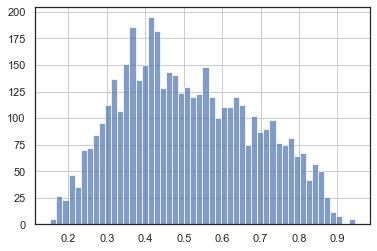

In [121]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_df['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

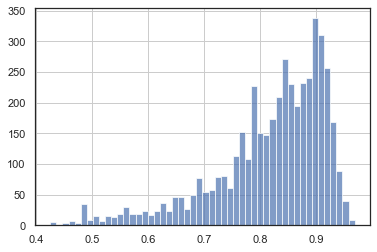

In [122]:
sns.set(style="white")
plt.figure()
score_df['max_3'].hist(alpha=.7, bins=50)

<AxesSubplot:>

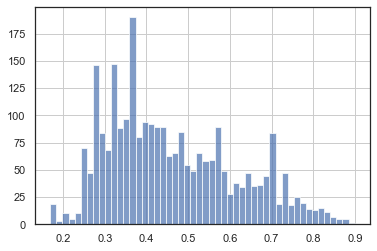

In [153]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_all_df[score_all_df.valid]['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

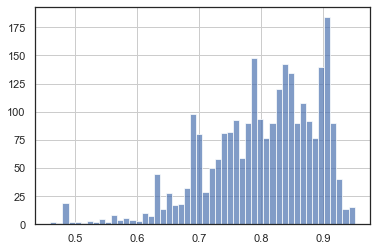

In [154]:
sns.set(style="white")
plt.figure()
score_all_df[score_all_df.valid]['max_3'].hist(alpha=.7, bins=50)

<AxesSubplot:>

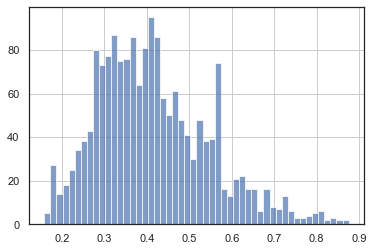

In [172]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_agg_df['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

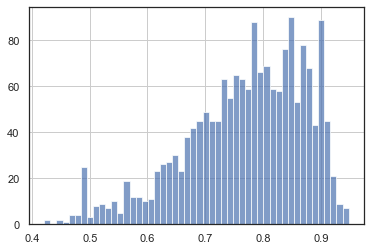

In [173]:
sns.set(style="white")
plt.figure()
score_agg_df['max_3'].hist(alpha=.7, bins=50)

In [196]:
compare = score_agg_df.merge(score_all_df, how = 'left', left_on='origin', right_on='origin')

In [197]:
compare['max_1_eq'] = compare['max_1_col_x']==compare['max_1_col_y']

In [198]:
compare['max_1_eq'].mean()

0.7143668370244179

In [204]:
compare[compare['counts']>1]['max_1_eq'].mean()

0.6076443057722309

In [209]:
compare['max_3_eq'] = compare.apply(lambda x: IoU([x['max_1_col_x'],x['max_2_col_x'],x['max_3_col_x']],
                                                 [x['max_1_col_y'],x['max_2_col_y'],x['max_3_col_y']]),axis=1)

In [210]:
compare['max_3_eq'].mean()

0.7912549687677457

In [211]:
compare[compare['counts']>1]['max_3_eq'].mean()

0.7132605304212168

In [218]:
cp_dict_1 = {'max_{}_col_x'.format(i):'max_{}_col_agg'.format(i) for i in range(1,4,1)}

In [219]:
cp_dict_1

{'max_1_col_x': 'max_1_col_agg',
 'max_2_col_x': 'max_2_col_agg',
 'max_3_col_x': 'max_3_col_agg'}

In [220]:
compare.rename(columns=cp_dict_1)

,origin,Criteria i_x,Criteria ii_x,Criteria iii_x,Criteria iv_x,Criteria v_x,Criteria vi_x,Criteria vii_x,Criteria viii_x,Criteria ix_x,...,max_1_col_y,max_2_val_y,max_2_col_y,max_3_val_y,max_3_col_y,max_1_y,max_3_y,valid,max_1_eq,max_3_eq
0,3,0.108202,0.362388,0.100627,0.316636,0.007993,0.080306,0.001893,0.001501,0.001882,...,Criteria ii,0.316636,Criteria iv,0.108202,Criteria i,0.362388,0.787226,True,True,1.0
1,4,0.187734,0.638658,0.045533,0.071700,0.003141,0.030455,0.002387,0.002495,0.002434,...,Criteria ii,0.187734,Criteria i,0.071700,Criteria iv,0.638658,0.898091,True,True,1.0
2,5,0.268723,0.396352,0.098409,0.147769,0.006426,0.052501,0.003528,0.002869,0.002682,...,Criteria ii,0.268723,Criteria i,0.147769,Criteria iv,0.396352,0.812845,True,True,1.0
3,6,0.166850,0.060742,0.262364,0.093926,0.013019,0.339463,0.011579,0.008149,0.005851,...,Criteria vi,0.087540,Criteria iii,0.019475,Criteria iv,0.823930,0.930945,True,True,0.5
4,13,0.297606,0.106118,0.040643,0.342098,0.010639,0.143809,0.014660,0.004371,0.006247,...,Criteria vi,0.300255,Criteria iv,0.233114,Criteria i,0.337761,0.871130,True,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,4981,0.572119,0.206998,0.017704,0.124045,0.005686,0.022822,0.006441,0.005944,0.004237,...,Criteria i,0.207143,Criteria ii,0.124023,Criteria iv,0.571989,0.903156,True,True,1.0
1757,4982,0.572119,0.206998,0.017704,0.124045,0.005686,0.022822,0.006441,0.005944,0.004237,...,Criteria i,0.207143,Criteria ii,0.124023,Criteria iv,0.571989,0.903156,True,True,1.0
1758,4983,0.572119,0.206998,0.017704,0.124045,0.005686,0.022822,0.006441,0.005944,0.004237,...,Criteria i,0.207143,Criteria ii,0.124023,Criteria iv,0.571989,0.903156,True,True,1.0
1759,4984,0.572119,0.206998,0.017704,0.124045,0.005686,0.022822,0.006441,0.005944,0.004237,...,Criteria i,0.207143,Criteria ii,0.124023,Criteria iv,0.571989,0.903156,True,True,1.0


In [221]:
score_final = score_all_df.merge(compare.rename(columns=cp_dict_1)[['origin','max_1_col_agg','max_2_col_agg','max_3_col_agg',
                                                    'max_1_eq','max_3_eq']], how='left', left_on='origin',right_on='origin')

In [227]:
score_final

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,max_3_val,max_3_col,max_1,max_3,valid,max_1_col_agg,max_2_col_agg,max_3_col_agg,max_1_eq,max_3_eq
0,3,51870743082,1,https://live.staticflickr.com/65535/5187074308...,https://live.staticflickr.com/65535/5187074308...,https://live.staticflickr.com/65535/5187074308...,https://live.staticflickr.com/65535/5187074308...,47954272@N06,"Tallinn, Estonia",...,...,0.108202,Criteria i,0.362388,0.787226,True,Criteria ii,Criteria iv,Criteria i,True,1.0
1,4,51871789478,1,https://live.staticflickr.com/65535/5187178947...,https://live.staticflickr.com/65535/5187178947...,https://live.staticflickr.com/65535/5187178947...,https://live.staticflickr.com/65535/5187178947...,47954272@N06,"Tallinn, Estonia",...,...,0.071700,Criteria iv,0.638658,0.898091,True,Criteria ii,Criteria i,Criteria iv,True,1.0
2,5,51870742942,1,https://live.staticflickr.com/65535/5187074294...,https://live.staticflickr.com/65535/5187074294...,https://live.staticflickr.com/65535/5187074294...,https://live.staticflickr.com/65535/5187074294...,47954272@N06,"Tallinn, Estonia",...,...,0.147769,Criteria iv,0.396352,0.812845,True,Criteria ii,Criteria i,Criteria iv,True,1.0
3,6,51870380541,1,https://live.staticflickr.com/65535/5187038054...,https://live.staticflickr.com/65535/5187038054...,https://live.staticflickr.com/65535/5187038054...,https://live.staticflickr.com/65535/5187038054...,64148082@N02,NaN,VENEZIA. CARNEVALE 2019,...,0.019475,Criteria iv,0.823930,0.930945,True,Criteria vi,Criteria iii,Criteria i,True,0.5
4,13,51863124066,1,https://live.staticflickr.com/65535/5186312406...,https://live.staticflickr.com/65535/5186312406...,https://live.staticflickr.com/65535/5186312406...,https://live.staticflickr.com/65535/5186312406...,186704588@N07,NaN,Venice - Ponte dei Sospiri,...,0.233114,Criteria i,0.337761,0.871130,True,Criteria iv,Criteria i,Criteria vi,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,4981,51233430558,1,https://live.staticflickr.com/65535/5123343055...,https://live.staticflickr.com/65535/5123343055...,https://live.staticflickr.com/65535/5123343055...,https://live.staticflickr.com/65535/5123343055...,83293103@N00,"Milano, Italy",20210520_145859,...,0.124023,Criteria iv,0.571989,0.903156,True,Criteria i,Criteria ii,Criteria iv,True,1.0
2947,4982,51234286630,1,https://live.staticflickr.com/65535/5123428663...,https://live.staticflickr.com/65535/5123428663...,https://live.staticflickr.com/65535/5123428663...,https://live.staticflickr.com/65535/5123428663...,83293103@N00,"Milano, Italy",20210520_145745,...,0.124023,Criteria iv,0.571989,0.903156,True,Criteria i,Criteria ii,Criteria iv,True,1.0
2948,4983,51234294135,1,https://live.staticflickr.com/65535/5123429413...,https://live.staticflickr.com/65535/5123429413...,https://live.staticflickr.com/65535/5123429413...,https://live.staticflickr.com/65535/5123429413...,83293103@N00,"Milano, Italy",20210520_164727,...,0.124023,Criteria iv,0.571989,0.903156,True,Criteria i,Criteria ii,Criteria iv,True,1.0
2949,4984,51234291635,1,https://live.staticflickr.com/65535/5123429163...,https://live.staticflickr.com/65535/5123429163...,https://live.staticflickr.com/65535/5123429163...,https://live.staticflickr.com/65535/5123429163...,83293103@N00,"Milano, Italy",20210520_155646,...,0.124023,Criteria iv,0.571989,0.903156,True,Criteria i,Criteria ii,Criteria iv,True,1.0


In [229]:
score_df.to_csv('../../../Venice_Flickr/Venezia/data_storage/sentences_bert.csv',sep='\t', encoding='utf-8-sig')
score_final.to_csv('../../../Venice_Flickr/Venezia/data_storage/metadata_bert.csv',sep='\t', encoding='utf-8-sig')

In [411]:
score_df = pd.read_csv('../../../Venice_Flickr/Venezia/data_storage/sentences_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')
score_final = pd.read_csv('../../../Venice_Flickr/Venezia/data_storage/metadata_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')

<AxesSubplot:>

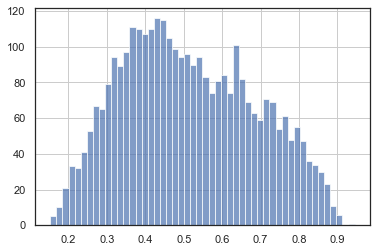

In [412]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_df.drop_duplicates('sentence')['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

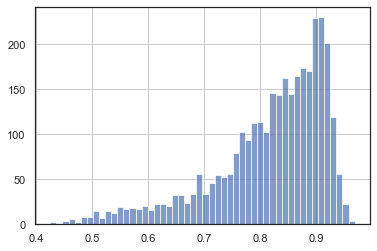

In [413]:
sns.set(style="white")
plt.figure()
score_df.drop_duplicates('sentence')['max_3'].hist(alpha=.7, bins=50)

C:\Users\zzbn1\AppData\Local\Temp\ipykernel_49176\363358714.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  score_final.drop_duplicates('revised_text')[score_final.valid]['max_1'].hist(alpha=.7, bins=50)


<AxesSubplot:>

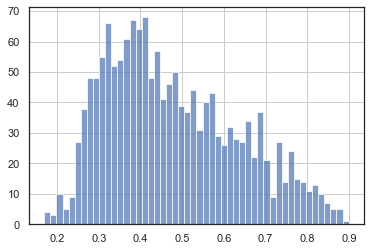

In [414]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_final.drop_duplicates('revised_text')[score_final.valid]['max_1'].hist(alpha=.7, bins=50)

C:\Users\zzbn1\AppData\Local\Temp\ipykernel_49176\470844744.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  score_final.drop_duplicates('revised_text')[score_final.valid]['max_3'].hist(alpha=.7, bins=50)


<AxesSubplot:>

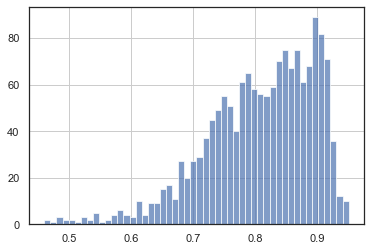

In [415]:
sns.set(style="white")
plt.figure()
score_final.drop_duplicates('revised_text')[score_final.valid]['max_3'].hist(alpha=.7, bins=50)

### Amsterdam

In [230]:
sm_df = pd.read_csv('../../../Venice_Flickr/Amsterdam/data_storage/sentences.csv',sep='\t', index_col = 'Unnamed: 0')

In [231]:
sm_all_df = pd.read_csv('../../../Venice_Flickr/Amsterdam/data_storage/metadata.csv',sep='\t', index_col = 'Unnamed: 0')

In [232]:
Results, Cls = predict_rating_proba(sm_df['sentence'], classifier, vectorizer, classes=classes, batch_size = 64)

D:\surfdrive\TUD\env\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0/149 batches finishes
1/149 batches finishes
2/149 batches finishes
3/149 batches finishes
4/149 batches finishes
5/149 batches finishes
6/149 batches finishes
7/149 batches finishes
8/149 batches finishes
9/149 batches finishes
10/149 batches finishes
11/149 batches finishes
12/149 batches finishes
13/149 batches finishes
14/149 batches finishes
15/149 batches finishes
16/149 batches finishes
17/149 batches finishes
18/149 batches finishes
19/149 batches finishes
20/149 batches finishes
21/149 batches finishes
22/149 batches finishes
23/149 batches finishes
24/149 batches finishes
25/149 batches finishes
26/149 batches finishes
27/149 batches finishes
28/149 batches finishes
29/149 batches finishes
30/149 batches finishes
31/149 batches finishes
32/149 batches finishes
33/149 batches finishes
34/149 batches finishes
35/149 batches finishes
36/149 batches finishes
37/149 batches finishes
38/149 batches finishes
39/149 batches finishes
40/149 batches finishes
41/149 batches finishes
42

In [235]:
Results_agg, Cls_agg = predict_rating_proba(sm_all_df['revised_text'], classifier, vectorizer, classes=classes, batch_size = 64)

0/58 batches finishes
1/58 batches finishes
2/58 batches finishes
3/58 batches finishes
4/58 batches finishes
5/58 batches finishes
6/58 batches finishes
7/58 batches finishes
8/58 batches finishes
9/58 batches finishes
10/58 batches finishes
11/58 batches finishes
12/58 batches finishes
13/58 batches finishes
14/58 batches finishes
15/58 batches finishes
16/58 batches finishes
17/58 batches finishes
18/58 batches finishes
19/58 batches finishes
20/58 batches finishes
21/58 batches finishes
22/58 batches finishes
23/58 batches finishes
24/58 batches finishes
25/58 batches finishes
26/58 batches finishes
27/58 batches finishes
28/58 batches finishes
29/58 batches finishes
30/58 batches finishes
31/58 batches finishes
32/58 batches finishes
33/58 batches finishes
34/58 batches finishes
35/58 batches finishes
36/58 batches finishes
37/58 batches finishes
38/58 batches finishes
39/58 batches finishes
40/58 batches finishes
41/58 batches finishes
42/58 batches finishes
43/58 batches finishe

In [236]:
test_ouv = sm_all_df['revised_text'].iloc[109]
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
It has tags of nederland, netherlands, paysbas, amsterdam. Amsterdam - 8 Jan 2017 -> Criteria ii with a probability of 0.83
It has tags of nederland, netherlands, paysbas, amsterdam. Amsterdam - 8 Jan 2017 -> Criteria i with a probability of 0.06
It has tags of nederland, netherlands, paysbas, amsterdam. Amsterdam - 8 Jan 2017 -> Criteria iv with a probability of 0.05


In [237]:
sm_df = sm_df.merge(pd.DataFrame(Results.cpu()).rename(columns=class_dict), how='left', left_index=True, right_index=True)
sm_df = sm_df.merge(pd.DataFrame(Cls.cpu()).rename(columns=bert_dict), how='left', left_index=True, right_index=True)

In [238]:
sm_all_df = sm_all_df.reset_index().rename(columns={'level_0':'origin'}).merge(pd.DataFrame(Results_agg.cpu()).rename(columns=class_dict), how='left', left_index=True, right_index=True)
sm_all_df = sm_all_df.merge(pd.DataFrame(Cls_agg.cpu()).rename(columns=bert_dict), how='left', left_index=True, right_index=True)

In [239]:
sm_all_df

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,BERT_758,BERT_759,BERT_760,BERT_761,BERT_762,BERT_763,BERT_764,BERT_765,BERT_766,BERT_767
0,2,51885929339,1.0,https://live.staticflickr.com/65535/5188592933...,https://live.staticflickr.com/65535/5188592933...,https://live.staticflickr.com/65535/5188592933...,https://live.staticflickr.com/65535/5188592933...,8733637@N04,"Haarlem, The Netherlands",Citroën 2CV 1982,...,0.656063,-0.335220,-0.048518,-0.186194,0.854062,-0.106939,0.818891,0.384767,0.734528,-0.240206
1,3,51884357517,1.0,https://live.staticflickr.com/65535/5188435751...,https://live.staticflickr.com/65535/5188435751...,https://live.staticflickr.com/65535/5188435751...,https://live.staticflickr.com/65535/5188435751...,150614452@N05,NaN,RFO 9901,...,0.644296,-0.455726,0.683729,-0.164840,0.773545,-0.160097,0.801759,-0.423844,0.549450,0.060106
2,8,51883860957,1.0,https://live.staticflickr.com/65535/5188386095...,https://live.staticflickr.com/65535/5188386095...,https://live.staticflickr.com/65535/5188386095...,https://live.staticflickr.com/65535/5188386095...,195032295@N04,NaN,"Houseboats, Amsterdam-West",...,-0.207838,-0.121478,0.990663,0.137630,0.855692,0.691311,0.201139,-0.454767,0.101105,0.820950
3,9,51884423594,1.0,https://live.staticflickr.com/65535/5188442359...,https://live.staticflickr.com/65535/5188442359...,https://live.staticflickr.com/65535/5188442359...,https://live.staticflickr.com/65535/5188442359...,8733637@N04,"Haarlem, The Netherlands",Ford Transit minibus 1978,...,0.634046,-0.626915,0.417425,-0.257386,0.694971,-0.360518,0.827499,-0.117803,0.702044,-0.414770
4,13,51882154188,1.0,https://live.staticflickr.com/65535/5188215418...,https://live.staticflickr.com/65535/5188215418...,https://live.staticflickr.com/65535/5188215418...,https://live.staticflickr.com/65535/5188215418...,8733637@N04,"Haarlem, The Netherlands",Renault Dauphine 1960,...,0.694398,-0.781786,0.653008,-0.456740,0.744507,-0.762171,0.848493,-0.554656,0.663841,-0.632983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3722,4993,51361633644,1.0,https://live.staticflickr.com/65535/5136163364...,https://live.staticflickr.com/65535/5136163364...,https://live.staticflickr.com/65535/5136163364...,https://live.staticflickr.com/65535/5136163364...,78239672@N00,"Kingston upon Hull, UK",Rijksmuseum,...,0.410113,-0.893430,0.966025,-0.115987,-0.513059,-0.356976,0.774055,-0.156261,0.645543,-0.273348
3723,4995,51357996868,1.0,https://live.staticflickr.com/65535/5135799686...,https://live.staticflickr.com/65535/5135799686...,https://live.staticflickr.com/65535/5135799686...,https://live.staticflickr.com/65535/5135799686...,193393816@N06,NaN,AMSTERDAM,...,0.699377,0.500002,-0.795076,0.581279,0.899655,0.892458,0.797160,0.934200,0.878161,0.401655
3724,4996,51356750697,1.0,https://live.staticflickr.com/65535/5135675069...,https://live.staticflickr.com/65535/5135675069...,https://live.staticflickr.com/65535/5135675069...,https://live.staticflickr.com/65535/5135675069...,34476863@N00,the netherlands,NaN,...,0.482168,-0.228867,0.782180,0.881605,-0.018688,0.582655,0.652794,0.569882,-0.410740,0.886711
3725,4997,51358508460,1.0,https://live.staticflickr.com/65535/5135850846...,https://live.staticflickr.com/65535/5135850846...,https://live.staticflickr.com/65535/5135850846...,https://live.staticflickr.com/65535/5135850846...,34476863@N00,the netherlands,NaN,...,0.482168,-0.228867,0.782180,0.881605,-0.018688,0.582655,0.652794,0.569882,-0.410740,0.886711


In [240]:
a = sm_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [241]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_df = pd.concat([sm_df, df1, df2], axis=1).reindex(c, axis=1)

In [242]:
score_df['max_1'] = score_df['max_1_val']
score_df['max_3'] = score_df['max_1_val']+score_df['max_2_val']+score_df['max_3_val']
score_df

,index,sentence,origin,lang,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,...,BERT_766,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0,"Amsterdam, the Netherlands.",2,en,0.142302,0.613584,0.033604,0.114368,0.007062,0.038919,...,0.823750,0.598916,0.613584,Criteria ii,0.142302,Criteria i,0.114368,Criteria iv,0.613584,0.870255
1,1,"It has tags of citro, citro, eend, geit, deuch...",2,en,0.067704,0.170978,0.030062,0.557452,0.017852,0.127049,...,0.728472,-0.094057,0.557452,Criteria iv,0.170978,Criteria ii,0.127049,Criteria vi,0.557452,0.855478
2,2,"It has tags of xt, rfo, station, amsterdam, wh...",3,en,0.055612,0.104151,0.120792,0.509236,0.033778,0.112375,...,0.549450,0.060106,0.509236,Criteria iv,0.120792,Criteria iii,0.112375,Criteria vi,0.509236,0.742402
3,4,There was a single swan in the water which see...,8,en,0.096401,0.010414,0.051497,0.054470,0.043407,0.096124,...,-0.438962,0.746187,0.485290,Criteria vii,0.096401,Criteria i,0.096124,Criteria vi,0.485290,0.677814
4,6,It has title of Ford Transit minibus 1978,9,en,0.034096,0.302022,0.065662,0.349770,0.038628,0.155254,...,0.801603,-0.415707,0.349770,Criteria iv,0.302022,Criteria ii,0.155254,Criteria vi,0.349770,0.807046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9594,2498,"It has tags of Holland, Netherlands, Amsterdam",4936,other,0.074664,0.819251,0.017535,0.050233,0.003286,0.013226,...,0.881062,0.335289,0.819251,Criteria ii,0.074664,Criteria i,0.050233,Criteria iv,0.819251,0.944148
9595,2499,"It has tags of Holland, Netherlands, Amsterdam",4937,other,0.074664,0.819251,0.017535,0.050233,0.003286,0.013226,...,0.881062,0.335289,0.819251,Criteria ii,0.074664,Criteria i,0.050233,Criteria iv,0.819251,0.944148
9596,2538,It has title of Ben Paul H087 Municipal museum...,4985,other,0.275405,0.569107,0.031185,0.055734,0.003697,0.012832,...,0.811676,0.903536,0.569107,Criteria ii,0.275405,Criteria i,0.055734,Criteria iv,0.569107,0.900247
9597,2542,It has title of Rijksmuseum,4993,other,0.145588,0.498142,0.067416,0.197442,0.007795,0.029427,...,0.695847,0.646813,0.498142,Criteria ii,0.197442,Criteria iv,0.145588,Criteria i,0.498142,0.841173


In [243]:
a = sm_all_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_all_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [244]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_all_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_all_df = pd.concat([sm_all_df, df1, df2], axis=1).reindex(c, axis=1)

In [245]:
score_all_df['max_1'] = score_all_df['max_1_val']
score_all_df['max_3'] = score_all_df['max_1_val']+score_all_df['max_2_val']+score_all_df['max_3_val']
score_all_df['valid'] = score_all_df['revised_text'].apply(lambda x: str(x)!='nan')
score_all_df

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,valid
0,2,51885929339,1.0,https://live.staticflickr.com/65535/5188592933...,https://live.staticflickr.com/65535/5188592933...,https://live.staticflickr.com/65535/5188592933...,https://live.staticflickr.com/65535/5188592933...,8733637@N04,"Haarlem, The Netherlands",Citroën 2CV 1982,...,-0.240206,0.531683,Criteria iv,0.237520,Criteria ii,0.108675,Criteria vi,0.531683,0.877878,True
1,3,51884357517,1.0,https://live.staticflickr.com/65535/5188435751...,https://live.staticflickr.com/65535/5188435751...,https://live.staticflickr.com/65535/5188435751...,https://live.staticflickr.com/65535/5188435751...,150614452@N05,NaN,RFO 9901,...,0.060106,0.509236,Criteria iv,0.120792,Criteria iii,0.112375,Criteria vi,0.509236,0.742402,True
2,8,51883860957,1.0,https://live.staticflickr.com/65535/5188386095...,https://live.staticflickr.com/65535/5188386095...,https://live.staticflickr.com/65535/5188386095...,https://live.staticflickr.com/65535/5188386095...,195032295@N04,NaN,"Houseboats, Amsterdam-West",...,0.820950,0.289079,Criteria i,0.271280,Criteria iv,0.126965,Criteria iii,0.289079,0.687324,True
3,9,51884423594,1.0,https://live.staticflickr.com/65535/5188442359...,https://live.staticflickr.com/65535/5188442359...,https://live.staticflickr.com/65535/5188442359...,https://live.staticflickr.com/65535/5188442359...,8733637@N04,"Haarlem, The Netherlands",Ford Transit minibus 1978,...,-0.414770,0.470036,Criteria iv,0.238715,Criteria vi,0.137283,Criteria ii,0.470036,0.846035,True
4,13,51882154188,1.0,https://live.staticflickr.com/65535/5188215418...,https://live.staticflickr.com/65535/5188215418...,https://live.staticflickr.com/65535/5188215418...,https://live.staticflickr.com/65535/5188215418...,8733637@N04,"Haarlem, The Netherlands",Renault Dauphine 1960,...,-0.632983,0.440501,Criteria iv,0.305510,Criteria vi,0.083700,Criteria ii,0.440501,0.829711,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3722,4993,51361633644,1.0,https://live.staticflickr.com/65535/5136163364...,https://live.staticflickr.com/65535/5136163364...,https://live.staticflickr.com/65535/5136163364...,https://live.staticflickr.com/65535/5136163364...,78239672@N00,"Kingston upon Hull, UK",Rijksmuseum,...,-0.273348,0.461521,Criteria vi,0.160636,Criteria iii,0.140929,Criteria iv,0.461521,0.763086,True
3723,4995,51357996868,1.0,https://live.staticflickr.com/65535/5135799686...,https://live.staticflickr.com/65535/5135799686...,https://live.staticflickr.com/65535/5135799686...,https://live.staticflickr.com/65535/5135799686...,193393816@N06,NaN,AMSTERDAM,...,0.401655,0.729162,Criteria ii,0.125762,Criteria i,0.050643,Criteria iv,0.729162,0.905567,True
3724,4996,51356750697,1.0,https://live.staticflickr.com/65535/5135675069...,https://live.staticflickr.com/65535/5135675069...,https://live.staticflickr.com/65535/5135675069...,https://live.staticflickr.com/65535/5135675069...,34476863@N00,the netherlands,NaN,...,0.886711,0.271104,Criteria i,0.180074,Criteria x,0.114719,Criteria iii,0.271104,0.565897,False
3725,4997,51358508460,1.0,https://live.staticflickr.com/65535/5135850846...,https://live.staticflickr.com/65535/5135850846...,https://live.staticflickr.com/65535/5135850846...,https://live.staticflickr.com/65535/5135850846...,34476863@N00,the netherlands,NaN,...,0.886711,0.271104,Criteria i,0.180074,Criteria x,0.114719,Criteria iii,0.271104,0.565897,False


In [246]:
sm_agg_df = sm_df.groupby('origin').mean().drop('index',axis=1).reset_index()
sm_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,...,BERT_758,BERT_759,BERT_760,BERT_761,BERT_762,BERT_763,BERT_764,BERT_765,BERT_766,BERT_767
0,2,0.105003,0.392281,0.031833,0.335910,0.012457,0.082984,0.003815,0.003408,0.004136,...,0.648915,-0.321808,0.361958,0.154414,0.230725,0.358582,0.841944,0.565764,0.776111,0.252429
1,3,0.055612,0.104151,0.120792,0.509236,0.033778,0.112375,0.009284,0.005430,0.009551,...,0.644296,-0.455726,0.683729,-0.164840,0.773545,-0.160097,0.801759,-0.423844,0.549450,0.060106
2,8,0.115501,0.071898,0.064082,0.251923,0.042456,0.061157,0.255248,0.015774,0.022727,...,-0.151871,0.256541,0.386071,0.106944,0.716179,0.431240,0.004030,0.009395,0.002310,0.741871
3,9,0.074711,0.343133,0.049153,0.304271,0.027664,0.149141,0.005870,0.004050,0.007706,...,0.584310,-0.297558,0.389544,0.052329,0.400048,0.111532,0.827943,0.257920,0.768387,-0.049321
4,13,0.079349,0.276764,0.062533,0.340662,0.031777,0.143502,0.009316,0.005149,0.011968,...,0.651926,-0.465072,0.495091,-0.051382,0.401733,-0.058594,0.835399,0.103011,0.728570,-0.043923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,4990,0.108473,0.028486,0.022206,0.038335,0.009271,0.707603,0.021859,0.007765,0.008313,...,-0.298236,-0.783544,0.979446,0.169639,-0.138971,-0.175504,0.428708,0.515421,0.370948,0.634347
2900,4991,0.378455,0.180821,0.084650,0.145355,0.014194,0.103362,0.017677,0.009043,0.008166,...,0.378428,-0.366930,0.774703,0.561383,0.705782,0.812206,0.705886,0.655739,0.502526,0.805964
2901,4993,0.104913,0.245792,0.121696,0.140456,0.029810,0.157409,0.057545,0.016127,0.022820,...,0.383814,-0.470849,0.585190,0.338489,-0.328067,0.480882,0.685768,0.036905,0.373514,0.297067
2902,4995,0.125670,0.729283,0.046187,0.050647,0.002971,0.018610,0.002195,0.003437,0.004132,...,0.699273,0.500147,-0.794784,0.580440,0.899716,0.892220,0.797197,0.934242,0.878206,0.400915


In [247]:
a = sm_agg_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_agg_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [248]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_agg_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_agg_df = pd.concat([sm_agg_df, df1, df2], axis=1).reindex(c, axis=1)

In [249]:
score_agg_df['max_1'] = score_agg_df['max_1_val']
score_agg_df['max_3'] = score_agg_df['max_1_val']+score_agg_df['max_2_val']+score_agg_df['max_3_val']
score_agg_df['counts'] = sm_df[['origin','BERT_0']].groupby('origin').count().reset_index()['BERT_0']
score_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,...,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,counts
0,2,0.105003,0.392281,0.031833,0.335910,0.012457,0.082984,0.003815,0.003408,0.004136,...,0.252429,0.392281,Criteria ii,0.335910,Criteria iv,0.105003,Criteria i,0.392281,0.833194,2
1,3,0.055612,0.104151,0.120792,0.509236,0.033778,0.112375,0.009284,0.005430,0.009551,...,0.060106,0.509236,Criteria iv,0.120792,Criteria iii,0.112375,Criteria vi,0.509236,0.742402,1
2,8,0.115501,0.071898,0.064082,0.251923,0.042456,0.061157,0.255248,0.015774,0.022727,...,0.741871,0.255248,Criteria vii,0.251923,Criteria iv,0.115501,Criteria i,0.255248,0.622672,2
3,9,0.074711,0.343133,0.049153,0.304271,0.027664,0.149141,0.005870,0.004050,0.007706,...,-0.049321,0.343133,Criteria ii,0.304271,Criteria iv,0.149141,Criteria vi,0.343133,0.796544,3
4,13,0.079349,0.276764,0.062533,0.340662,0.031777,0.143502,0.009316,0.005149,0.011968,...,-0.043923,0.340662,Criteria iv,0.276764,Criteria ii,0.143502,Criteria vi,0.340662,0.760929,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,4990,0.108473,0.028486,0.022206,0.038335,0.009271,0.707603,0.021859,0.007765,0.008313,...,0.634347,0.707603,Criteria vi,0.108473,Criteria i,0.038335,Criteria iv,0.707603,0.854412,1
2900,4991,0.378455,0.180821,0.084650,0.145355,0.014194,0.103362,0.017677,0.009043,0.008166,...,0.805964,0.378455,Criteria i,0.180821,Criteria ii,0.145355,Criteria iv,0.378455,0.704631,2
2901,4993,0.104913,0.245792,0.121696,0.140456,0.029810,0.157409,0.057545,0.016127,0.022820,...,0.297067,0.245792,Criteria ii,0.157409,Criteria vi,0.140456,Criteria iv,0.245792,0.543657,5
2902,4995,0.125670,0.729283,0.046187,0.050647,0.002971,0.018610,0.002195,0.003437,0.004132,...,0.400915,0.729283,Criteria ii,0.125670,Criteria i,0.050647,Criteria iv,0.729283,0.905600,1


In [250]:
score_df['max_1_col'].value_counts()

Criteria ii      2972
Criteria vi      1732
Criteria i       1637
Criteria iv      1477
Criteria iii      725
Criteria vii      524
Criteria viii     262
Criteria x        261
Criteria ix         5
Criteria v          4
Name: max_1_col, dtype: int64

In [251]:
pd.concat([score_df['max_1_col'],score_df['max_2_col'],score_df['max_3_col']]).value_counts()

Criteria iv      6921
Criteria i       6069
Criteria ii      5408
Criteria vi      4526
Criteria iii     2569
Criteria vii     1449
Criteria x       1030
Criteria viii     305
Criteria ix       286
Criteria v        234
dtype: int64

In [252]:
score_all_df[score_all_df.valid]['max_1_col'].value_counts()

Criteria vi      940
Criteria ii      739
Criteria i       530
Criteria iv      519
Criteria viii    258
Criteria iii     100
Criteria vii      68
Criteria x        18
Name: max_1_col, dtype: int64

In [253]:
pd.concat([score_all_df[score_all_df.valid]['max_1_col'],
           score_all_df[score_all_df.valid]['max_2_col'],
           score_all_df[score_all_df.valid]['max_3_col']]).value_counts()

Criteria iv      2450
Criteria ii      2008
Criteria i       1736
Criteria vi      1496
Criteria iii      839
Criteria vii      435
Criteria viii     296
Criteria x        142
Criteria ix        73
Criteria v         41
dtype: int64

In [254]:
score_agg_df['max_1_col'].value_counts()

Criteria ii      898
Criteria i       591
Criteria vi      495
Criteria iv      454
Criteria viii    258
Criteria iii     112
Criteria vii      74
Criteria x        21
Criteria ix        1
Name: max_1_col, dtype: int64

In [255]:
pd.concat([score_agg_df['max_1_col'],score_agg_df['max_2_col'],score_agg_df['max_3_col']]).value_counts()

Criteria ii      2101
Criteria iv      2071
Criteria i       1826
Criteria vi      1190
Criteria iii      531
Criteria vii      455
Criteria viii     293
Criteria x        166
Criteria ix        71
Criteria v          8
dtype: int64

<AxesSubplot:>

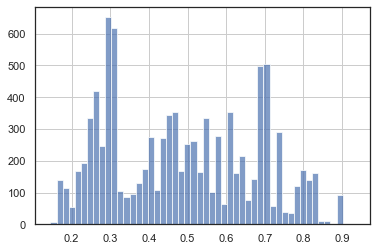

In [256]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_df['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

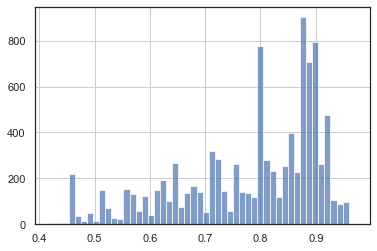

In [257]:
sns.set(style="white")
plt.figure()
score_df['max_3'].hist(alpha=.7, bins=50)

<AxesSubplot:>

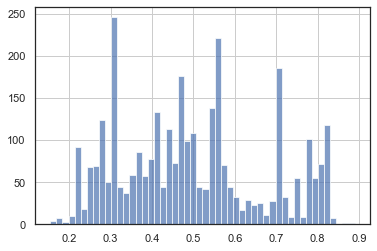

In [258]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_all_df[score_all_df.valid]['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

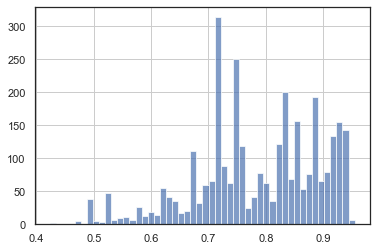

In [259]:
sns.set(style="white")
plt.figure()
score_all_df[score_all_df.valid]['max_3'].hist(alpha=.7, bins=50)

<AxesSubplot:>

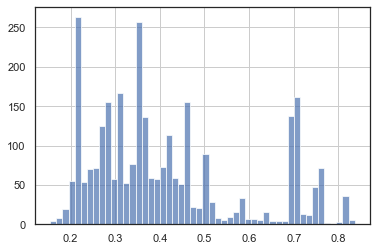

In [260]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_agg_df['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

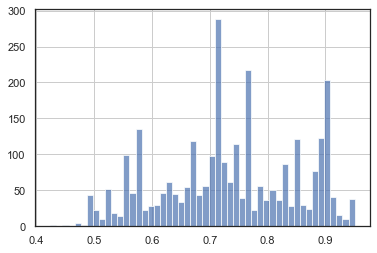

In [261]:
sns.set(style="white")
plt.figure()
score_agg_df['max_3'].hist(alpha=.7, bins=50)

In [262]:
compare = score_agg_df.merge(score_all_df, how = 'left', left_on='origin', right_on='origin')

In [263]:
compare['max_1_eq'] = compare['max_1_col_x']==compare['max_1_col_y']

In [264]:
compare['max_1_eq'].mean()

0.775137741046832

In [265]:
compare[compare['counts']>1]['max_1_eq'].mean()

0.6277080957810718

In [267]:
compare['max_3_eq'] = compare.apply(lambda x: IoU([x['max_1_col_x'],x['max_2_col_x'],x['max_3_col_x']],
                                                 [x['max_1_col_y'],x['max_2_col_y'],x['max_3_col_y']]),axis=1)

In [268]:
compare['max_3_eq'].mean()

0.8397727272727273

In [269]:
compare[compare['counts']>1]['max_3_eq'].mean()

0.734720638540479

In [270]:
cp_dict_1 = {'max_{}_col_x'.format(i):'max_{}_col_agg'.format(i) for i in range(1,4,1)}

In [271]:
cp_dict_1

{'max_1_col_x': 'max_1_col_agg',
 'max_2_col_x': 'max_2_col_agg',
 'max_3_col_x': 'max_3_col_agg'}

In [272]:
compare.rename(columns=cp_dict_1)

,origin,Criteria i_x,Criteria ii_x,Criteria iii_x,Criteria iv_x,Criteria v_x,Criteria vi_x,Criteria vii_x,Criteria viii_x,Criteria ix_x,...,max_1_col_y,max_2_val_y,max_2_col_y,max_3_val_y,max_3_col_y,max_1_y,max_3_y,valid,max_1_eq,max_3_eq
0,2,0.105003,0.392281,0.031833,0.335910,0.012457,0.082984,0.003815,0.003408,0.004136,...,Criteria iv,0.237520,Criteria ii,0.108675,Criteria vi,0.531683,0.877878,True,False,0.5
1,3,0.055612,0.104151,0.120792,0.509236,0.033778,0.112375,0.009284,0.005430,0.009551,...,Criteria iv,0.120792,Criteria iii,0.112375,Criteria vi,0.509236,0.742402,True,True,1.0
2,8,0.115501,0.071898,0.064082,0.251923,0.042456,0.061157,0.255248,0.015774,0.022727,...,Criteria i,0.271280,Criteria iv,0.126965,Criteria iii,0.289079,0.687324,True,False,0.5
3,9,0.074711,0.343133,0.049153,0.304271,0.027664,0.149141,0.005870,0.004050,0.007706,...,Criteria iv,0.238715,Criteria vi,0.137283,Criteria ii,0.470036,0.846035,True,False,1.0
4,13,0.079349,0.276764,0.062533,0.340662,0.031777,0.143502,0.009316,0.005149,0.011968,...,Criteria iv,0.305510,Criteria vi,0.083700,Criteria ii,0.440501,0.829711,True,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,4990,0.108473,0.028486,0.022206,0.038335,0.009271,0.707603,0.021859,0.007765,0.008313,...,Criteria vi,0.108458,Criteria i,0.038351,Criteria iv,0.707430,0.854239,True,True,1.0
2900,4991,0.378455,0.180821,0.084650,0.145355,0.014194,0.103362,0.017677,0.009043,0.008166,...,Criteria i,0.147771,Criteria iv,0.120508,Criteria vi,0.382015,0.650294,True,True,0.5
2901,4993,0.104913,0.245792,0.121696,0.140456,0.029810,0.157409,0.057545,0.016127,0.022820,...,Criteria vi,0.160636,Criteria iii,0.140929,Criteria iv,0.461521,0.763086,True,False,0.5
2902,4995,0.125670,0.729283,0.046187,0.050647,0.002971,0.018610,0.002195,0.003437,0.004132,...,Criteria ii,0.125762,Criteria i,0.050643,Criteria iv,0.729162,0.905567,True,True,1.0


In [273]:
score_final = score_all_df.merge(compare.rename(columns=cp_dict_1)[['origin','max_1_col_agg','max_2_col_agg','max_3_col_agg',
                                                    'max_1_eq','max_3_eq']], how='left', left_on='origin',right_on='origin')

In [274]:
score_final

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,max_3_val,max_3_col,max_1,max_3,valid,max_1_col_agg,max_2_col_agg,max_3_col_agg,max_1_eq,max_3_eq
0,2,51885929339,1.0,https://live.staticflickr.com/65535/5188592933...,https://live.staticflickr.com/65535/5188592933...,https://live.staticflickr.com/65535/5188592933...,https://live.staticflickr.com/65535/5188592933...,8733637@N04,"Haarlem, The Netherlands",Citroën 2CV 1982,...,0.108675,Criteria vi,0.531683,0.877878,True,Criteria ii,Criteria iv,Criteria i,False,0.5
1,3,51884357517,1.0,https://live.staticflickr.com/65535/5188435751...,https://live.staticflickr.com/65535/5188435751...,https://live.staticflickr.com/65535/5188435751...,https://live.staticflickr.com/65535/5188435751...,150614452@N05,NaN,RFO 9901,...,0.112375,Criteria vi,0.509236,0.742402,True,Criteria iv,Criteria iii,Criteria vi,True,1.0
2,8,51883860957,1.0,https://live.staticflickr.com/65535/5188386095...,https://live.staticflickr.com/65535/5188386095...,https://live.staticflickr.com/65535/5188386095...,https://live.staticflickr.com/65535/5188386095...,195032295@N04,NaN,"Houseboats, Amsterdam-West",...,0.126965,Criteria iii,0.289079,0.687324,True,Criteria vii,Criteria iv,Criteria i,False,0.5
3,9,51884423594,1.0,https://live.staticflickr.com/65535/5188442359...,https://live.staticflickr.com/65535/5188442359...,https://live.staticflickr.com/65535/5188442359...,https://live.staticflickr.com/65535/5188442359...,8733637@N04,"Haarlem, The Netherlands",Ford Transit minibus 1978,...,0.137283,Criteria ii,0.470036,0.846035,True,Criteria ii,Criteria iv,Criteria vi,False,1.0
4,13,51882154188,1.0,https://live.staticflickr.com/65535/5188215418...,https://live.staticflickr.com/65535/5188215418...,https://live.staticflickr.com/65535/5188215418...,https://live.staticflickr.com/65535/5188215418...,8733637@N04,"Haarlem, The Netherlands",Renault Dauphine 1960,...,0.083700,Criteria ii,0.440501,0.829711,True,Criteria iv,Criteria ii,Criteria vi,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3722,4993,51361633644,1.0,https://live.staticflickr.com/65535/5136163364...,https://live.staticflickr.com/65535/5136163364...,https://live.staticflickr.com/65535/5136163364...,https://live.staticflickr.com/65535/5136163364...,78239672@N00,"Kingston upon Hull, UK",Rijksmuseum,...,0.140929,Criteria iv,0.461521,0.763086,True,Criteria ii,Criteria vi,Criteria iv,False,0.5
3723,4995,51357996868,1.0,https://live.staticflickr.com/65535/5135799686...,https://live.staticflickr.com/65535/5135799686...,https://live.staticflickr.com/65535/5135799686...,https://live.staticflickr.com/65535/5135799686...,193393816@N06,NaN,AMSTERDAM,...,0.050643,Criteria iv,0.729162,0.905567,True,Criteria ii,Criteria i,Criteria iv,True,1.0
3724,4996,51356750697,1.0,https://live.staticflickr.com/65535/5135675069...,https://live.staticflickr.com/65535/5135675069...,https://live.staticflickr.com/65535/5135675069...,https://live.staticflickr.com/65535/5135675069...,34476863@N00,the netherlands,NaN,...,0.114719,Criteria iii,0.271104,0.565897,False,NaN,NaN,NaN,NaN,NaN
3725,4997,51358508460,1.0,https://live.staticflickr.com/65535/5135850846...,https://live.staticflickr.com/65535/5135850846...,https://live.staticflickr.com/65535/5135850846...,https://live.staticflickr.com/65535/5135850846...,34476863@N00,the netherlands,NaN,...,0.114719,Criteria iii,0.271104,0.565897,False,NaN,NaN,NaN,NaN,NaN


In [275]:
score_df.to_csv('../../../Venice_Flickr/Amsterdam/data_storage/sentences_bert.csv',sep='\t', encoding='utf-8-sig')
score_final.to_csv('../../../Venice_Flickr/Amsterdam/data_storage/metadata_bert.csv',sep='\t', encoding='utf-8-sig')

In [406]:
score_df = pd.read_csv('../../../Venice_Flickr/Amsterdam/data_storage/sentences_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')
score_final = pd.read_csv('../../../Venice_Flickr/Amsterdam/data_storage/metadata_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')

<AxesSubplot:>

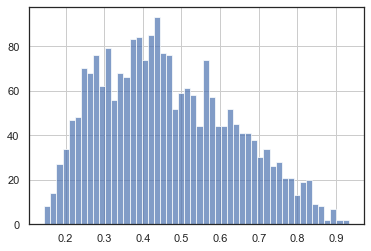

In [407]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_df.drop_duplicates('sentence')['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

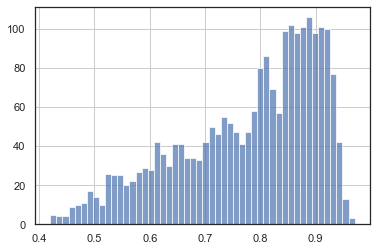

In [408]:
sns.set(style="white")
plt.figure()
score_df.drop_duplicates('sentence')['max_3'].hist(alpha=.7, bins=50)

C:\Users\zzbn1\AppData\Local\Temp\ipykernel_49176\363358714.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  score_final.drop_duplicates('revised_text')[score_final.valid]['max_1'].hist(alpha=.7, bins=50)


<AxesSubplot:>

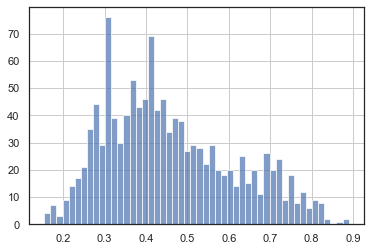

In [409]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_final.drop_duplicates('revised_text')[score_final.valid]['max_1'].hist(alpha=.7, bins=50)

C:\Users\zzbn1\AppData\Local\Temp\ipykernel_49176\470844744.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  score_final.drop_duplicates('revised_text')[score_final.valid]['max_3'].hist(alpha=.7, bins=50)


<AxesSubplot:>

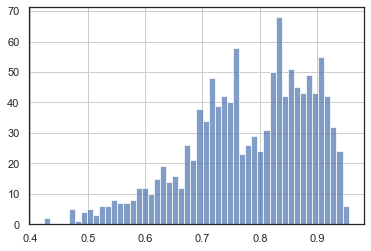

In [410]:
sns.set(style="white")
plt.figure()
score_final.drop_duplicates('revised_text')[score_final.valid]['max_3'].hist(alpha=.7, bins=50)

### Suzhou

In [276]:
sm_df = pd.read_csv('../../../Venice_Flickr/Suzhou/data_storage/sentences.csv',sep='\t', index_col = 'Unnamed: 0')

In [277]:
sm_all_df = pd.read_csv('../../../Venice_Flickr/Suzhou/data_storage/metadata.csv',sep='\t', index_col = 'Unnamed: 0')

In [278]:
Results, Cls = predict_rating_proba(sm_df['sentence'], classifier, vectorizer, classes=classes, batch_size = 64)

D:\surfdrive\TUD\env\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0/15 batches finishes
1/15 batches finishes
2/15 batches finishes
3/15 batches finishes
4/15 batches finishes
5/15 batches finishes
6/15 batches finishes
7/15 batches finishes
8/15 batches finishes
9/15 batches finishes
10/15 batches finishes
11/15 batches finishes
12/15 batches finishes
13/15 batches finishes
14/15 batches finishes


In [279]:
Results_agg, Cls_agg = predict_rating_proba(sm_all_df['revised_text'], classifier, vectorizer, classes=classes, batch_size = 64)

0/49 batches finishes
1/49 batches finishes
2/49 batches finishes
3/49 batches finishes
4/49 batches finishes
5/49 batches finishes
6/49 batches finishes
7/49 batches finishes
8/49 batches finishes
9/49 batches finishes
10/49 batches finishes
11/49 batches finishes
12/49 batches finishes
13/49 batches finishes
14/49 batches finishes
15/49 batches finishes
16/49 batches finishes
17/49 batches finishes
18/49 batches finishes
19/49 batches finishes
20/49 batches finishes
21/49 batches finishes
22/49 batches finishes
23/49 batches finishes
24/49 batches finishes
25/49 batches finishes
26/49 batches finishes
27/49 batches finishes
28/49 batches finishes
29/49 batches finishes
30/49 batches finishes
31/49 batches finishes
32/49 batches finishes
33/49 batches finishes
34/49 batches finishes
35/49 batches finishes
36/49 batches finishes
37/49 batches finishes
38/49 batches finishes
39/49 batches finishes
40/49 batches finishes
41/49 batches finishes
42/49 batches finishes
43/49 batches finishe

In [280]:
test_ouv = sm_all_df['revised_text'].iloc[109]
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
It has title of Jiangnan in Yuan Dynasty -> Criteria iii with a probability of 0.45
It has title of Jiangnan in Yuan Dynasty -> Criteria vi with a probability of 0.25
It has title of Jiangnan in Yuan Dynasty -> Criteria iv with a probability of 0.11


In [281]:
sm_df = sm_df.merge(pd.DataFrame(Results.cpu()).rename(columns=class_dict), how='left', left_index=True, right_index=True)
sm_df = sm_df.merge(pd.DataFrame(Cls.cpu()).rename(columns=bert_dict), how='left', left_index=True, right_index=True)

In [282]:
sm_all_df = sm_all_df.reset_index().rename(columns={'level_0':'origin'}).merge(pd.DataFrame(Results_agg.cpu()).rename(columns=class_dict), how='left', left_index=True, right_index=True)
sm_all_df = sm_all_df.merge(pd.DataFrame(Cls_agg.cpu()).rename(columns=bert_dict), how='left', left_index=True, right_index=True)

In [283]:
sm_all_df

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,BERT_758,BERT_759,BERT_760,BERT_761,BERT_762,BERT_763,BERT_764,BERT_765,BERT_766,BERT_767
0,8,51859675789,1.0,https://live.staticflickr.com/65535/5185967578...,https://live.staticflickr.com/65535/5185967578...,https://live.staticflickr.com/65535/5185967578...,https://live.staticflickr.com/65535/5185967578...,57210421@N04,"Beijing, China",灭渡桥,...,-0.200190,0.970352,-0.972353,0.835688,-0.716197,0.100046,-0.158648,-0.339472,-0.280153,0.849620
1,9,51859339946,1.0,https://live.staticflickr.com/65535/5185933994...,https://live.staticflickr.com/65535/5185933994...,https://live.staticflickr.com/65535/5185933994...,https://live.staticflickr.com/65535/5185933994...,57210421@N04,"Beijing, China",灭渡桥,...,-0.200190,0.970352,-0.972353,0.835688,-0.716197,0.100046,-0.158648,-0.339472,-0.280153,0.849620
2,10,51858385807,1.0,https://live.staticflickr.com/65535/5185838580...,https://live.staticflickr.com/65535/5185838580...,https://live.staticflickr.com/65535/5185838580...,https://live.staticflickr.com/65535/5185838580...,57210421@N04,"Beijing, China",灭渡桥,...,-0.200190,0.970352,-0.972353,0.835688,-0.716197,0.100046,-0.158648,-0.339472,-0.280153,0.849620
3,11,51859339546,1.0,https://live.staticflickr.com/65535/5185933954...,https://live.staticflickr.com/65535/5185933954...,https://live.staticflickr.com/65535/5185933954...,https://live.staticflickr.com/65535/5185933954...,57210421@N04,"Beijing, China",灭渡桥,...,-0.200190,0.970352,-0.972353,0.835688,-0.716197,0.100046,-0.158648,-0.339472,-0.280153,0.849620
4,12,51858385377,1.0,https://live.staticflickr.com/65535/5185838537...,https://live.staticflickr.com/65535/5185838537...,https://live.staticflickr.com/65535/5185838537...,https://live.staticflickr.com/65535/5185838537...,57210421@N04,"Beijing, China",灭渡桥,...,-0.200190,0.970352,-0.972353,0.835688,-0.716197,0.100046,-0.158648,-0.339472,-0.280153,0.849620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132,4225,38397950426,1.0,https://live.staticflickr.com/4582/38397950426...,https://live.staticflickr.com/4582/38397950426...,https://live.staticflickr.com/4582/38397950426...,https://live.staticflickr.com/4582/38397950426...,28571579@N03,NaN,20171112_IMG_0515,...,0.480980,-0.228134,0.781274,0.881367,-0.018970,0.582935,0.651811,0.570092,-0.410744,0.886437
3133,4226,38397948496,1.0,https://live.staticflickr.com/4517/38397948496...,https://live.staticflickr.com/4517/38397948496...,https://live.staticflickr.com/4517/38397948496...,https://live.staticflickr.com/4517/38397948496...,28571579@N03,NaN,20171112_IMG_0518,...,0.480980,-0.228134,0.781274,0.881367,-0.018970,0.582935,0.651811,0.570092,-0.410744,0.886437
3134,4227,38454117381,1.0,https://live.staticflickr.com/4552/38454117381...,https://live.staticflickr.com/4552/38454117381...,https://live.staticflickr.com/4552/38454117381...,https://live.staticflickr.com/4552/38454117381...,28571579@N03,NaN,20171112_IMG_0531,...,0.480980,-0.228134,0.781274,0.881367,-0.018970,0.582935,0.651811,0.570092,-0.410744,0.886437
3135,4228,38397940256,1.0,https://live.staticflickr.com/4576/38397940256...,https://live.staticflickr.com/4576/38397940256...,https://live.staticflickr.com/4576/38397940256...,https://live.staticflickr.com/4576/38397940256...,28571579@N03,NaN,20171112_IMG_0539,...,0.480980,-0.228134,0.781274,0.881367,-0.018970,0.582935,0.651811,0.570092,-0.410744,0.886437


In [284]:
a = sm_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [285]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_df = pd.concat([sm_df, df1, df2], axis=1).reindex(c, axis=1)

In [286]:
score_df['max_1'] = score_df['max_1_val']
score_df['max_3'] = score_df['max_1_val']+score_df['max_2_val']+score_df['max_3_val']
score_df

,index,sentence,origin,lang,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,...,BERT_766,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0,"It has title of ""Raining Soochow""",104,en,0.132901,0.025626,0.111723,0.045728,0.036301,0.158634,...,-0.050052,0.825894,0.191816,Criteria vii,0.158634,Criteria vi,0.158438,Criteria x,0.191816,0.508888
1,1,"It has title of ""Glow In the Dark""",106,en,0.185117,0.042183,0.066849,0.053831,0.021639,0.058710,...,-0.135458,0.975341,0.224774,Criteria x,0.185117,Criteria i,0.181310,Criteria vii,0.224774,0.591201
2,5,and a family (in the background),131,en,0.033132,0.110547,0.314518,0.330711,0.114962,0.039835,...,0.101699,-0.195817,0.330711,Criteria iv,0.314518,Criteria iii,0.114962,Criteria v,0.330711,0.760191
3,6,It has title of Goldfishes,131,en,0.008342,0.004857,0.015115,0.002584,0.007281,0.002083,...,-0.617588,0.887453,0.722116,Criteria x,0.110830,Criteria vii,0.087265,Criteria ix,0.722116,0.920210
4,7,It has title of Tetrahedral shadow and rockery,132,en,0.059658,0.027018,0.067757,0.438848,0.072322,0.105282,...,0.609779,0.456196,0.438848,Criteria iv,0.108198,Criteria vii,0.105282,Criteria vi,0.438848,0.652328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,1761,"It has tags of suzhoushi, jiangsusheng, china, cn",4116,other,0.164054,0.185454,0.247030,0.153396,0.013783,0.177106,...,0.592267,0.389208,0.247030,Criteria iii,0.185454,Criteria ii,0.177106,Criteria vi,0.247030,0.609589
980,1763,"It has tags of suzhoushi, jiangsusheng, china, cn",4117,other,0.164054,0.185454,0.247030,0.153396,0.013783,0.177106,...,0.592267,0.389208,0.247030,Criteria iii,0.185454,Criteria ii,0.177106,Criteria vi,0.247030,0.609589
981,1764,Canglang Pavilion 20171120 adam0730,4129,other,0.619855,0.059418,0.058423,0.116926,0.008782,0.027466,...,0.137768,0.965384,0.619855,Criteria i,0.116926,Criteria iv,0.059418,Criteria ii,0.619855,0.796199
982,1773,It has tags of chinasuzhou,4139,other,0.069314,0.085946,0.398199,0.126585,0.033287,0.147490,...,0.419786,0.380366,0.398199,Criteria iii,0.147490,Criteria vi,0.126585,Criteria iv,0.398199,0.672273


In [287]:
a = sm_all_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_all_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [288]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_all_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_all_df = pd.concat([sm_all_df, df1, df2], axis=1).reindex(c, axis=1)

In [289]:
score_all_df['max_1'] = score_all_df['max_1_val']
score_all_df['max_3'] = score_all_df['max_1_val']+score_all_df['max_2_val']+score_all_df['max_3_val']
score_all_df['valid'] = score_all_df['revised_text'].apply(lambda x: str(x)!='nan')
score_all_df

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,valid
0,8,51859675789,1.0,https://live.staticflickr.com/65535/5185967578...,https://live.staticflickr.com/65535/5185967578...,https://live.staticflickr.com/65535/5185967578...,https://live.staticflickr.com/65535/5185967578...,57210421@N04,"Beijing, China",灭渡桥,...,0.849620,0.592425,Criteria ix,0.174640,Criteria x,0.131084,Criteria viii,0.592425,0.898149,True
1,9,51859339946,1.0,https://live.staticflickr.com/65535/5185933994...,https://live.staticflickr.com/65535/5185933994...,https://live.staticflickr.com/65535/5185933994...,https://live.staticflickr.com/65535/5185933994...,57210421@N04,"Beijing, China",灭渡桥,...,0.849620,0.592425,Criteria ix,0.174640,Criteria x,0.131084,Criteria viii,0.592425,0.898149,True
2,10,51858385807,1.0,https://live.staticflickr.com/65535/5185838580...,https://live.staticflickr.com/65535/5185838580...,https://live.staticflickr.com/65535/5185838580...,https://live.staticflickr.com/65535/5185838580...,57210421@N04,"Beijing, China",灭渡桥,...,0.849620,0.592425,Criteria ix,0.174640,Criteria x,0.131084,Criteria viii,0.592425,0.898149,True
3,11,51859339546,1.0,https://live.staticflickr.com/65535/5185933954...,https://live.staticflickr.com/65535/5185933954...,https://live.staticflickr.com/65535/5185933954...,https://live.staticflickr.com/65535/5185933954...,57210421@N04,"Beijing, China",灭渡桥,...,0.849620,0.592425,Criteria ix,0.174640,Criteria x,0.131084,Criteria viii,0.592425,0.898149,True
4,12,51858385377,1.0,https://live.staticflickr.com/65535/5185838537...,https://live.staticflickr.com/65535/5185838537...,https://live.staticflickr.com/65535/5185838537...,https://live.staticflickr.com/65535/5185838537...,57210421@N04,"Beijing, China",灭渡桥,...,0.849620,0.592425,Criteria ix,0.174640,Criteria x,0.131084,Criteria viii,0.592425,0.898149,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132,4225,38397950426,1.0,https://live.staticflickr.com/4582/38397950426...,https://live.staticflickr.com/4582/38397950426...,https://live.staticflickr.com/4582/38397950426...,https://live.staticflickr.com/4582/38397950426...,28571579@N03,NaN,20171112_IMG_0515,...,0.886437,0.270940,Criteria i,0.180150,Criteria x,0.114688,Criteria iii,0.270940,0.565778,False
3133,4226,38397948496,1.0,https://live.staticflickr.com/4517/38397948496...,https://live.staticflickr.com/4517/38397948496...,https://live.staticflickr.com/4517/38397948496...,https://live.staticflickr.com/4517/38397948496...,28571579@N03,NaN,20171112_IMG_0518,...,0.886437,0.270940,Criteria i,0.180150,Criteria x,0.114688,Criteria iii,0.270940,0.565778,False
3134,4227,38454117381,1.0,https://live.staticflickr.com/4552/38454117381...,https://live.staticflickr.com/4552/38454117381...,https://live.staticflickr.com/4552/38454117381...,https://live.staticflickr.com/4552/38454117381...,28571579@N03,NaN,20171112_IMG_0531,...,0.886437,0.270940,Criteria i,0.180150,Criteria x,0.114688,Criteria iii,0.270940,0.565778,False
3135,4228,38397940256,1.0,https://live.staticflickr.com/4576/38397940256...,https://live.staticflickr.com/4576/38397940256...,https://live.staticflickr.com/4576/38397940256...,https://live.staticflickr.com/4576/38397940256...,28571579@N03,NaN,20171112_IMG_0539,...,0.886437,0.270940,Criteria i,0.180150,Criteria x,0.114688,Criteria iii,0.270940,0.565778,False


In [290]:
sm_agg_df = sm_df.groupby('origin').mean().drop('index',axis=1).reset_index()
sm_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,...,BERT_758,BERT_759,BERT_760,BERT_761,BERT_762,BERT_763,BERT_764,BERT_765,BERT_766,BERT_767
0,8,0.010054,0.007108,0.007631,0.004291,0.005318,0.001989,0.047457,0.131084,0.592425,...,-0.200190,0.970352,-0.972353,0.835688,-0.716197,0.100046,-0.158648,-0.339472,-0.280153,0.849620
1,13,0.108291,0.161188,0.125806,0.428398,0.016782,0.112502,0.009894,0.003371,0.005956,...,0.549835,-0.202512,0.814241,-0.272024,0.443693,0.348547,0.795192,-0.517190,0.749508,0.260672
2,16,0.100739,0.081079,0.200934,0.287148,0.022578,0.252345,0.010383,0.003865,0.006858,...,0.383941,-0.585109,0.958539,-0.196449,0.208300,-0.276832,0.736083,-0.553178,0.713309,0.225526
3,23,0.027742,0.037852,0.450524,0.108325,0.032643,0.253816,0.018643,0.008190,0.009253,...,-0.020295,-0.854055,0.984204,0.008744,-0.886767,-0.437410,0.350859,-0.959854,0.309420,-0.221529
4,104,0.132901,0.025626,0.111723,0.045728,0.036301,0.158634,0.191816,0.046889,0.029190,...,-0.389965,-0.766400,0.989296,0.724965,-0.149065,0.624717,0.101048,-0.269639,-0.050052,0.825894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,4129,0.575090,0.038327,0.055035,0.072426,0.010903,0.032256,0.136795,0.013601,0.008778,...,-0.168267,0.061037,0.707678,0.730662,0.716898,0.895015,-0.002266,0.394811,0.237785,0.950156
750,4136,0.035708,0.050034,0.759633,0.077378,0.013366,0.037065,0.003645,0.001782,0.001880,...,0.299247,-0.627528,0.906777,0.207094,-0.640424,-0.130526,0.556529,-0.344576,0.280538,-0.260825
751,4137,0.035708,0.050034,0.759633,0.077378,0.013366,0.037065,0.003645,0.001782,0.001880,...,0.299247,-0.627528,0.906777,0.207094,-0.640424,-0.130526,0.556529,-0.344576,0.280538,-0.260825
752,4139,0.389788,0.074115,0.219946,0.104202,0.022274,0.083335,0.023517,0.007700,0.010406,...,0.316048,-0.117484,0.872554,0.551502,0.281997,0.504360,0.458335,0.188555,0.427816,0.601117


In [291]:
a = sm_agg_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_agg_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [292]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_agg_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_agg_df = pd.concat([sm_agg_df, df1, df2], axis=1).reindex(c, axis=1)

In [293]:
score_agg_df['max_1'] = score_agg_df['max_1_val']
score_agg_df['max_3'] = score_agg_df['max_1_val']+score_agg_df['max_2_val']+score_agg_df['max_3_val']
score_agg_df['counts'] = sm_df[['origin','BERT_0']].groupby('origin').count().reset_index()['BERT_0']
score_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,...,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,counts
0,8,0.010054,0.007108,0.007631,0.004291,0.005318,0.001989,0.047457,0.131084,0.592425,...,0.849620,0.592425,Criteria ix,0.174640,Criteria x,0.131084,Criteria viii,0.592425,0.898149,1
1,13,0.108291,0.161188,0.125806,0.428398,0.016782,0.112502,0.009894,0.003371,0.005956,...,0.260672,0.428398,Criteria iv,0.161188,Criteria ii,0.125806,Criteria iii,0.428398,0.715392,1
2,16,0.100739,0.081079,0.200934,0.287148,0.022578,0.252345,0.010383,0.003865,0.006858,...,0.225526,0.287148,Criteria iv,0.252345,Criteria vi,0.200934,Criteria iii,0.287148,0.740426,1
3,23,0.027742,0.037852,0.450524,0.108325,0.032643,0.253816,0.018643,0.008190,0.009253,...,-0.221529,0.450524,Criteria iii,0.253816,Criteria vi,0.108325,Criteria iv,0.450524,0.812665,1
4,104,0.132901,0.025626,0.111723,0.045728,0.036301,0.158634,0.191816,0.046889,0.029190,...,0.825894,0.191816,Criteria vii,0.158634,Criteria vi,0.158438,Criteria x,0.191816,0.508888,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,4129,0.575090,0.038327,0.055035,0.072426,0.010903,0.032256,0.136795,0.013601,0.008778,...,0.950156,0.575090,Criteria i,0.136795,Criteria vii,0.072426,Criteria iv,0.575090,0.784311,3
750,4136,0.035708,0.050034,0.759633,0.077378,0.013366,0.037065,0.003645,0.001782,0.001880,...,-0.260825,0.759633,Criteria iii,0.077378,Criteria iv,0.050034,Criteria ii,0.759633,0.887045,1
751,4137,0.035708,0.050034,0.759633,0.077378,0.013366,0.037065,0.003645,0.001782,0.001880,...,-0.260825,0.759633,Criteria iii,0.077378,Criteria iv,0.050034,Criteria ii,0.759633,0.887045,1
752,4139,0.389788,0.074115,0.219946,0.104202,0.022274,0.083335,0.023517,0.007700,0.010406,...,0.601117,0.389788,Criteria i,0.219946,Criteria iii,0.104202,Criteria iv,0.389788,0.713935,2


In [294]:
score_df['max_1_col'].value_counts()

Criteria vi     328
Criteria iii    191
Criteria i      180
Criteria ii     142
Criteria iv      51
Criteria x       48
Criteria vii     40
Criteria v        3
Criteria ix       1
Name: max_1_col, dtype: int64

In [295]:
pd.concat([score_df['max_1_col'],score_df['max_2_col'],score_df['max_3_col']]).value_counts()

Criteria vi      657
Criteria iv      584
Criteria ii      565
Criteria iii     559
Criteria i       369
Criteria x        85
Criteria vii      71
Criteria v        26
Criteria ix       19
Criteria viii     17
dtype: int64

In [296]:
score_all_df[score_all_df.valid]['max_1_col'].value_counts()

Criteria iii    439
Criteria vi     345
Criteria i      202
Criteria ii     118
Criteria iv      82
Criteria vii     54
Criteria x       36
Criteria ix       9
Criteria v        2
Name: max_1_col, dtype: int64

In [297]:
pd.concat([score_all_df[score_all_df.valid]['max_1_col'],
           score_all_df[score_all_df.valid]['max_2_col'],
           score_all_df[score_all_df.valid]['max_3_col']]).value_counts()

Criteria vi      901
Criteria iv      861
Criteria iii     821
Criteria ii      624
Criteria i       419
Criteria x        94
Criteria vii      68
Criteria v        27
Criteria viii     27
Criteria ix       19
dtype: int64

In [298]:
score_agg_df['max_1_col'].value_counts()

Criteria vi     274
Criteria i      148
Criteria iii    129
Criteria ii     123
Criteria x       38
Criteria iv      20
Criteria vii     20
Criteria ix       1
Criteria v        1
Name: max_1_col, dtype: int64

In [299]:
pd.concat([score_agg_df['max_1_col'],score_agg_df['max_2_col'],score_agg_df['max_3_col']]).value_counts()

Criteria vi      529
Criteria ii      495
Criteria iii     442
Criteria iv      425
Criteria i       269
Criteria x        51
Criteria vii      39
Criteria v         7
Criteria ix        4
Criteria viii      1
dtype: int64

<AxesSubplot:>

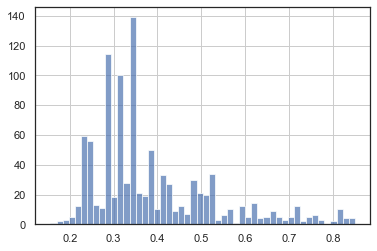

In [300]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_df['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

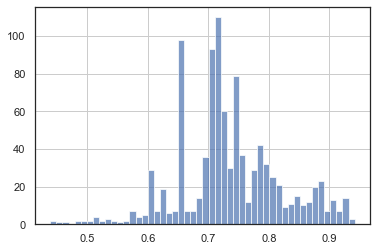

In [301]:
sns.set(style="white")
plt.figure()
score_df['max_3'].hist(alpha=.7, bins=50)

<AxesSubplot:>

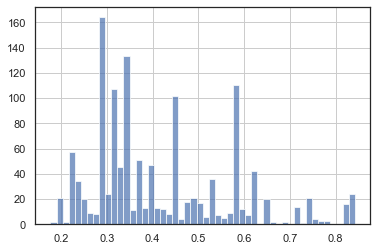

In [302]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_all_df[score_all_df.valid]['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

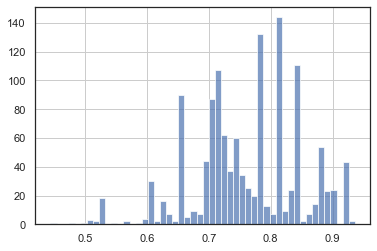

In [303]:
sns.set(style="white")
plt.figure()
score_all_df[score_all_df.valid]['max_3'].hist(alpha=.7, bins=50)

<AxesSubplot:>

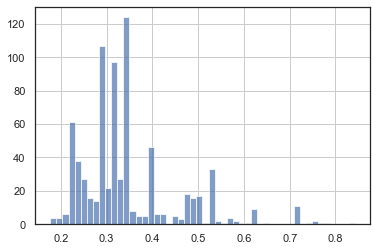

In [304]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_agg_df['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

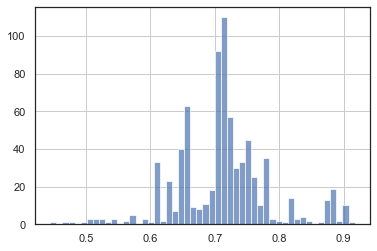

In [305]:
sns.set(style="white")
plt.figure()
score_agg_df['max_3'].hist(alpha=.7, bins=50)

In [306]:
compare = score_agg_df.merge(score_all_df, how = 'left', left_on='origin', right_on='origin')

In [307]:
compare['max_1_eq'] = compare['max_1_col_x']==compare['max_1_col_y']

In [308]:
compare['max_1_eq'].mean()

0.9230769230769231

In [309]:
compare[compare['counts']>1]['max_1_eq'].mean()

0.5797101449275363

In [310]:
compare['max_3_eq'] = compare.apply(lambda x: IoU([x['max_1_col_x'],x['max_2_col_x'],x['max_3_col_x']],
                                                 [x['max_1_col_y'],x['max_2_col_y'],x['max_3_col_y']]),axis=1)

In [311]:
compare['max_3_eq'].mean()

0.9380636604774535

In [312]:
compare[compare['counts']>1]['max_3_eq'].mean()

0.6615942028985508

In [313]:
cp_dict_1 = {'max_{}_col_x'.format(i):'max_{}_col_agg'.format(i) for i in range(1,4,1)}

In [314]:
cp_dict_1

{'max_1_col_x': 'max_1_col_agg',
 'max_2_col_x': 'max_2_col_agg',
 'max_3_col_x': 'max_3_col_agg'}

In [315]:
compare.rename(columns=cp_dict_1)

,origin,Criteria i_x,Criteria ii_x,Criteria iii_x,Criteria iv_x,Criteria v_x,Criteria vi_x,Criteria vii_x,Criteria viii_x,Criteria ix_x,...,max_1_col_y,max_2_val_y,max_2_col_y,max_3_val_y,max_3_col_y,max_1_y,max_3_y,valid,max_1_eq,max_3_eq
0,8,0.010054,0.007108,0.007631,0.004291,0.005318,0.001989,0.047457,0.131084,0.592425,...,Criteria ix,0.174640,Criteria x,0.131084,Criteria viii,0.592425,0.898149,True,True,1.0
1,13,0.108291,0.161188,0.125806,0.428398,0.016782,0.112502,0.009894,0.003371,0.005956,...,Criteria iv,0.161188,Criteria ii,0.125806,Criteria iii,0.428398,0.715392,True,True,1.0
2,16,0.100739,0.081079,0.200934,0.287148,0.022578,0.252345,0.010383,0.003865,0.006858,...,Criteria iv,0.252345,Criteria vi,0.200934,Criteria iii,0.287148,0.740426,True,True,1.0
3,23,0.027742,0.037852,0.450524,0.108325,0.032643,0.253816,0.018643,0.008190,0.009253,...,Criteria iii,0.253816,Criteria vi,0.108325,Criteria iv,0.450524,0.812665,True,True,1.0
4,104,0.132901,0.025626,0.111723,0.045728,0.036301,0.158634,0.191816,0.046889,0.029190,...,Criteria vii,0.158634,Criteria vi,0.158438,Criteria x,0.191816,0.508888,True,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,4129,0.575090,0.038327,0.055035,0.072426,0.010903,0.032256,0.136795,0.013601,0.008778,...,Criteria i,0.065801,Criteria vi,0.055072,Criteria iii,0.694318,0.815191,True,True,0.2
750,4136,0.035708,0.050034,0.759633,0.077378,0.013366,0.037065,0.003645,0.001782,0.001880,...,Criteria iii,0.077378,Criteria iv,0.050034,Criteria ii,0.759633,0.887045,True,True,1.0
751,4137,0.035708,0.050034,0.759633,0.077378,0.013366,0.037065,0.003645,0.001782,0.001880,...,Criteria iii,0.077378,Criteria iv,0.050034,Criteria ii,0.759633,0.887045,True,True,1.0
752,4139,0.389788,0.074115,0.219946,0.104202,0.022274,0.083335,0.023517,0.007700,0.010406,...,Criteria i,0.148396,Criteria iii,0.125969,Criteria iv,0.512632,0.786996,True,True,1.0


In [320]:
score_all_df

,origin,index,candownload,url_c,url_q,url_n,url_largest,owner,owner_loc,title,...,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,valid
0,8,51859675789,1.0,https://live.staticflickr.com/65535/5185967578...,https://live.staticflickr.com/65535/5185967578...,https://live.staticflickr.com/65535/5185967578...,https://live.staticflickr.com/65535/5185967578...,57210421@N04,"Beijing, China",灭渡桥,...,0.849620,0.592425,Criteria ix,0.174640,Criteria x,0.131084,Criteria viii,0.592425,0.898149,True
1,9,51859339946,1.0,https://live.staticflickr.com/65535/5185933994...,https://live.staticflickr.com/65535/5185933994...,https://live.staticflickr.com/65535/5185933994...,https://live.staticflickr.com/65535/5185933994...,57210421@N04,"Beijing, China",灭渡桥,...,0.849620,0.592425,Criteria ix,0.174640,Criteria x,0.131084,Criteria viii,0.592425,0.898149,True
2,10,51858385807,1.0,https://live.staticflickr.com/65535/5185838580...,https://live.staticflickr.com/65535/5185838580...,https://live.staticflickr.com/65535/5185838580...,https://live.staticflickr.com/65535/5185838580...,57210421@N04,"Beijing, China",灭渡桥,...,0.849620,0.592425,Criteria ix,0.174640,Criteria x,0.131084,Criteria viii,0.592425,0.898149,True
3,11,51859339546,1.0,https://live.staticflickr.com/65535/5185933954...,https://live.staticflickr.com/65535/5185933954...,https://live.staticflickr.com/65535/5185933954...,https://live.staticflickr.com/65535/5185933954...,57210421@N04,"Beijing, China",灭渡桥,...,0.849620,0.592425,Criteria ix,0.174640,Criteria x,0.131084,Criteria viii,0.592425,0.898149,True
4,12,51858385377,1.0,https://live.staticflickr.com/65535/5185838537...,https://live.staticflickr.com/65535/5185838537...,https://live.staticflickr.com/65535/5185838537...,https://live.staticflickr.com/65535/5185838537...,57210421@N04,"Beijing, China",灭渡桥,...,0.849620,0.592425,Criteria ix,0.174640,Criteria x,0.131084,Criteria viii,0.592425,0.898149,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132,4225,38397950426,1.0,https://live.staticflickr.com/4582/38397950426...,https://live.staticflickr.com/4582/38397950426...,https://live.staticflickr.com/4582/38397950426...,https://live.staticflickr.com/4582/38397950426...,28571579@N03,NaN,20171112_IMG_0515,...,0.886437,0.270940,Criteria i,0.180150,Criteria x,0.114688,Criteria iii,0.270940,0.565778,False
3133,4226,38397948496,1.0,https://live.staticflickr.com/4517/38397948496...,https://live.staticflickr.com/4517/38397948496...,https://live.staticflickr.com/4517/38397948496...,https://live.staticflickr.com/4517/38397948496...,28571579@N03,NaN,20171112_IMG_0518,...,0.886437,0.270940,Criteria i,0.180150,Criteria x,0.114688,Criteria iii,0.270940,0.565778,False
3134,4227,38454117381,1.0,https://live.staticflickr.com/4552/38454117381...,https://live.staticflickr.com/4552/38454117381...,https://live.staticflickr.com/4552/38454117381...,https://live.staticflickr.com/4552/38454117381...,28571579@N03,NaN,20171112_IMG_0531,...,0.886437,0.270940,Criteria i,0.180150,Criteria x,0.114688,Criteria iii,0.270940,0.565778,False
3135,4228,38397940256,1.0,https://live.staticflickr.com/4576/38397940256...,https://live.staticflickr.com/4576/38397940256...,https://live.staticflickr.com/4576/38397940256...,https://live.staticflickr.com/4576/38397940256...,28571579@N03,NaN,20171112_IMG_0539,...,0.886437,0.270940,Criteria i,0.180150,Criteria x,0.114688,Criteria iii,0.270940,0.565778,False


In [316]:
score_final = score_all_df.merge(compare.rename(columns=cp_dict_1)[['origin','max_1_col_agg','max_2_col_agg','max_3_col_agg',
                                                    'max_1_eq','max_3_eq']], how='left', left_on='origin',right_on='origin')

In [322]:
score_final['max_1_eq'].count()

754

In [318]:
score_df.to_csv('../../../Venice_Flickr/Suzhou/data_storage/sentences_bert.csv',sep='\t', encoding='utf-8-sig')
score_final.to_csv('../../../Venice_Flickr/Suzhou/data_storage/metadata_bert.csv',sep='\t', encoding='utf-8-sig')

In [400]:
score_df = pd.read_csv('../../../Venice_Flickr/Suzhou/data_storage/sentences_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')
score_final = pd.read_csv('../../../Venice_Flickr/Suzhou/data_storage/metadata_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')

C:\Users\zzbn1\AppData\Local\Temp\ipykernel_49176\539401478.py:2: DtypeWarning: Columns (824,825,826,827) have mixed types. Specify dtype option on import or set low_memory=False.
  score_final = pd.read_csv('../../../Venice_Flickr/Suzhou/data_storage/metadata_bert.csv',sep='\t', encoding='utf-8-sig', index_col='Unnamed: 0')


<AxesSubplot:>

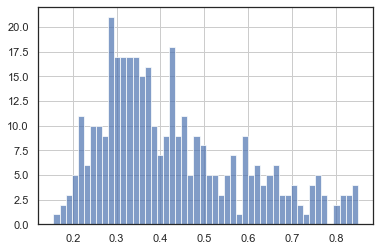

In [401]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_df.drop_duplicates('sentence')['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

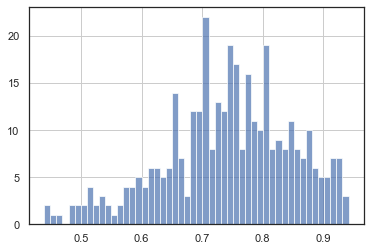

In [402]:
sns.set(style="white")
plt.figure()
score_df.drop_duplicates('sentence')['max_3'].hist(alpha=.7, bins=50)

C:\Users\zzbn1\AppData\Local\Temp\ipykernel_49176\363358714.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  score_final.drop_duplicates('revised_text')[score_final.valid]['max_1'].hist(alpha=.7, bins=50)


<AxesSubplot:>

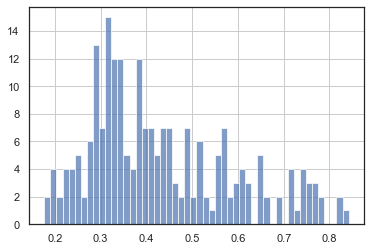

In [404]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_final.drop_duplicates('revised_text')[score_final.valid]['max_1'].hist(alpha=.7, bins=50)

C:\Users\zzbn1\AppData\Local\Temp\ipykernel_49176\470844744.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  score_final.drop_duplicates('revised_text')[score_final.valid]['max_3'].hist(alpha=.7, bins=50)


<AxesSubplot:>

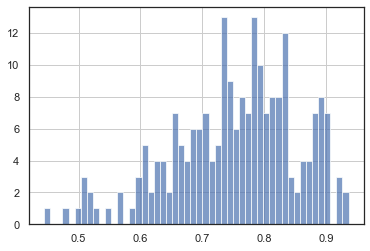

In [405]:
sns.set(style="white")
plt.figure()
score_final.drop_duplicates('revised_text')[score_final.valid]['max_3'].hist(alpha=.7, bins=50)

### Venice_Large

In [323]:
sm_df = pd.read_csv('../../../Venice_Flickr/data_storage/images/sentences.csv',sep='\t', index_col = 'Unnamed: 0')

In [324]:
sm_all_df = pd.read_csv('../../../Venice_Flickr/data_storage/images/metadata.csv',sep='\t', index_col = 'Unnamed: 0')

In [325]:
Results, Cls = predict_rating_proba(sm_df['sentence'], classifier, vectorizer, classes=classes, batch_size = 64)

D:\surfdrive\TUD\env\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0/2672 batches finishes
1/2672 batches finishes
2/2672 batches finishes
3/2672 batches finishes
4/2672 batches finishes
5/2672 batches finishes
6/2672 batches finishes
7/2672 batches finishes
8/2672 batches finishes
9/2672 batches finishes
10/2672 batches finishes
11/2672 batches finishes
12/2672 batches finishes
13/2672 batches finishes
14/2672 batches finishes
15/2672 batches finishes
16/2672 batches finishes
17/2672 batches finishes
18/2672 batches finishes
19/2672 batches finishes
20/2672 batches finishes
21/2672 batches finishes
22/2672 batches finishes
23/2672 batches finishes
24/2672 batches finishes
25/2672 batches finishes
26/2672 batches finishes
27/2672 batches finishes
28/2672 batches finishes
29/2672 batches finishes
30/2672 batches finishes
31/2672 batches finishes
32/2672 batches finishes
33/2672 batches finishes
34/2672 batches finishes
35/2672 batches finishes
36/2672 batches finishes
37/2672 batches finishes
38/2672 batches finishes
39/2672 batches finishes
40/2672 ba

320/2672 batches finishes
321/2672 batches finishes
322/2672 batches finishes
323/2672 batches finishes
324/2672 batches finishes
325/2672 batches finishes
326/2672 batches finishes
327/2672 batches finishes
328/2672 batches finishes
329/2672 batches finishes
330/2672 batches finishes
331/2672 batches finishes
332/2672 batches finishes
333/2672 batches finishes
334/2672 batches finishes
335/2672 batches finishes
336/2672 batches finishes
337/2672 batches finishes
338/2672 batches finishes
339/2672 batches finishes
340/2672 batches finishes
341/2672 batches finishes
342/2672 batches finishes
343/2672 batches finishes
344/2672 batches finishes
345/2672 batches finishes
346/2672 batches finishes
347/2672 batches finishes
348/2672 batches finishes
349/2672 batches finishes
350/2672 batches finishes
351/2672 batches finishes
352/2672 batches finishes
353/2672 batches finishes
354/2672 batches finishes
355/2672 batches finishes
356/2672 batches finishes
357/2672 batches finishes
358/2672 bat

636/2672 batches finishes
637/2672 batches finishes
638/2672 batches finishes
639/2672 batches finishes
640/2672 batches finishes
641/2672 batches finishes
642/2672 batches finishes
643/2672 batches finishes
644/2672 batches finishes
645/2672 batches finishes
646/2672 batches finishes
647/2672 batches finishes
648/2672 batches finishes
649/2672 batches finishes
650/2672 batches finishes
651/2672 batches finishes
652/2672 batches finishes
653/2672 batches finishes
654/2672 batches finishes
655/2672 batches finishes
656/2672 batches finishes
657/2672 batches finishes
658/2672 batches finishes
659/2672 batches finishes
660/2672 batches finishes
661/2672 batches finishes
662/2672 batches finishes
663/2672 batches finishes
664/2672 batches finishes
665/2672 batches finishes
666/2672 batches finishes
667/2672 batches finishes
668/2672 batches finishes
669/2672 batches finishes
670/2672 batches finishes
671/2672 batches finishes
672/2672 batches finishes
673/2672 batches finishes
674/2672 bat

952/2672 batches finishes
953/2672 batches finishes
954/2672 batches finishes
955/2672 batches finishes
956/2672 batches finishes
957/2672 batches finishes
958/2672 batches finishes
959/2672 batches finishes
960/2672 batches finishes
961/2672 batches finishes
962/2672 batches finishes
963/2672 batches finishes
964/2672 batches finishes
965/2672 batches finishes
966/2672 batches finishes
967/2672 batches finishes
968/2672 batches finishes
969/2672 batches finishes
970/2672 batches finishes
971/2672 batches finishes
972/2672 batches finishes
973/2672 batches finishes
974/2672 batches finishes
975/2672 batches finishes
976/2672 batches finishes
977/2672 batches finishes
978/2672 batches finishes
979/2672 batches finishes
980/2672 batches finishes
981/2672 batches finishes
982/2672 batches finishes
983/2672 batches finishes
984/2672 batches finishes
985/2672 batches finishes
986/2672 batches finishes
987/2672 batches finishes
988/2672 batches finishes
989/2672 batches finishes
990/2672 bat

1258/2672 batches finishes
1259/2672 batches finishes
1260/2672 batches finishes
1261/2672 batches finishes
1262/2672 batches finishes
1263/2672 batches finishes
1264/2672 batches finishes
1265/2672 batches finishes
1266/2672 batches finishes
1267/2672 batches finishes
1268/2672 batches finishes
1269/2672 batches finishes
1270/2672 batches finishes
1271/2672 batches finishes
1272/2672 batches finishes
1273/2672 batches finishes
1274/2672 batches finishes
1275/2672 batches finishes
1276/2672 batches finishes
1277/2672 batches finishes
1278/2672 batches finishes
1279/2672 batches finishes
1280/2672 batches finishes
1281/2672 batches finishes
1282/2672 batches finishes
1283/2672 batches finishes
1284/2672 batches finishes
1285/2672 batches finishes
1286/2672 batches finishes
1287/2672 batches finishes
1288/2672 batches finishes
1289/2672 batches finishes
1290/2672 batches finishes
1291/2672 batches finishes
1292/2672 batches finishes
1293/2672 batches finishes
1294/2672 batches finishes
1

1562/2672 batches finishes
1563/2672 batches finishes
1564/2672 batches finishes
1565/2672 batches finishes
1566/2672 batches finishes
1567/2672 batches finishes
1568/2672 batches finishes
1569/2672 batches finishes
1570/2672 batches finishes
1571/2672 batches finishes
1572/2672 batches finishes
1573/2672 batches finishes
1574/2672 batches finishes
1575/2672 batches finishes
1576/2672 batches finishes
1577/2672 batches finishes
1578/2672 batches finishes
1579/2672 batches finishes
1580/2672 batches finishes
1581/2672 batches finishes
1582/2672 batches finishes
1583/2672 batches finishes
1584/2672 batches finishes
1585/2672 batches finishes
1586/2672 batches finishes
1587/2672 batches finishes
1588/2672 batches finishes
1589/2672 batches finishes
1590/2672 batches finishes
1591/2672 batches finishes
1592/2672 batches finishes
1593/2672 batches finishes
1594/2672 batches finishes
1595/2672 batches finishes
1596/2672 batches finishes
1597/2672 batches finishes
1598/2672 batches finishes
1

1866/2672 batches finishes
1867/2672 batches finishes
1868/2672 batches finishes
1869/2672 batches finishes
1870/2672 batches finishes
1871/2672 batches finishes
1872/2672 batches finishes
1873/2672 batches finishes
1874/2672 batches finishes
1875/2672 batches finishes
1876/2672 batches finishes
1877/2672 batches finishes
1878/2672 batches finishes
1879/2672 batches finishes
1880/2672 batches finishes
1881/2672 batches finishes
1882/2672 batches finishes
1883/2672 batches finishes
1884/2672 batches finishes
1885/2672 batches finishes
1886/2672 batches finishes
1887/2672 batches finishes
1888/2672 batches finishes
1889/2672 batches finishes
1890/2672 batches finishes
1891/2672 batches finishes
1892/2672 batches finishes
1893/2672 batches finishes
1894/2672 batches finishes
1895/2672 batches finishes
1896/2672 batches finishes
1897/2672 batches finishes
1898/2672 batches finishes
1899/2672 batches finishes
1900/2672 batches finishes
1901/2672 batches finishes
1902/2672 batches finishes
1

2170/2672 batches finishes
2171/2672 batches finishes
2172/2672 batches finishes
2173/2672 batches finishes
2174/2672 batches finishes
2175/2672 batches finishes
2176/2672 batches finishes
2177/2672 batches finishes
2178/2672 batches finishes
2179/2672 batches finishes
2180/2672 batches finishes
2181/2672 batches finishes
2182/2672 batches finishes
2183/2672 batches finishes
2184/2672 batches finishes
2185/2672 batches finishes
2186/2672 batches finishes
2187/2672 batches finishes
2188/2672 batches finishes
2189/2672 batches finishes
2190/2672 batches finishes
2191/2672 batches finishes
2192/2672 batches finishes
2193/2672 batches finishes
2194/2672 batches finishes
2195/2672 batches finishes
2196/2672 batches finishes
2197/2672 batches finishes
2198/2672 batches finishes
2199/2672 batches finishes
2200/2672 batches finishes
2201/2672 batches finishes
2202/2672 batches finishes
2203/2672 batches finishes
2204/2672 batches finishes
2205/2672 batches finishes
2206/2672 batches finishes
2

2474/2672 batches finishes
2475/2672 batches finishes
2476/2672 batches finishes
2477/2672 batches finishes
2478/2672 batches finishes
2479/2672 batches finishes
2480/2672 batches finishes
2481/2672 batches finishes
2482/2672 batches finishes
2483/2672 batches finishes
2484/2672 batches finishes
2485/2672 batches finishes
2486/2672 batches finishes
2487/2672 batches finishes
2488/2672 batches finishes
2489/2672 batches finishes
2490/2672 batches finishes
2491/2672 batches finishes
2492/2672 batches finishes
2493/2672 batches finishes
2494/2672 batches finishes
2495/2672 batches finishes
2496/2672 batches finishes
2497/2672 batches finishes
2498/2672 batches finishes
2499/2672 batches finishes
2500/2672 batches finishes
2501/2672 batches finishes
2502/2672 batches finishes
2503/2672 batches finishes
2504/2672 batches finishes
2505/2672 batches finishes
2506/2672 batches finishes
2507/2672 batches finishes
2508/2672 batches finishes
2509/2672 batches finishes
2510/2672 batches finishes
2

In [326]:
Results_agg, Cls_agg = predict_rating_proba(sm_all_df['revised_text'], classifier, vectorizer, classes=classes, batch_size = 64)

0/1265 batches finishes
1/1265 batches finishes
2/1265 batches finishes
3/1265 batches finishes
4/1265 batches finishes
5/1265 batches finishes
6/1265 batches finishes
7/1265 batches finishes
8/1265 batches finishes
9/1265 batches finishes
10/1265 batches finishes
11/1265 batches finishes
12/1265 batches finishes
13/1265 batches finishes
14/1265 batches finishes
15/1265 batches finishes
16/1265 batches finishes
17/1265 batches finishes
18/1265 batches finishes
19/1265 batches finishes
20/1265 batches finishes
21/1265 batches finishes
22/1265 batches finishes
23/1265 batches finishes
24/1265 batches finishes
25/1265 batches finishes
26/1265 batches finishes
27/1265 batches finishes
28/1265 batches finishes
29/1265 batches finishes
30/1265 batches finishes
31/1265 batches finishes
32/1265 batches finishes
33/1265 batches finishes
34/1265 batches finishes
35/1265 batches finishes
36/1265 batches finishes
37/1265 batches finishes
38/1265 batches finishes
39/1265 batches finishes
40/1265 ba

320/1265 batches finishes
321/1265 batches finishes
322/1265 batches finishes
323/1265 batches finishes
324/1265 batches finishes
325/1265 batches finishes
326/1265 batches finishes
327/1265 batches finishes
328/1265 batches finishes
329/1265 batches finishes
330/1265 batches finishes
331/1265 batches finishes
332/1265 batches finishes
333/1265 batches finishes
334/1265 batches finishes
335/1265 batches finishes
336/1265 batches finishes
337/1265 batches finishes
338/1265 batches finishes
339/1265 batches finishes
340/1265 batches finishes
341/1265 batches finishes
342/1265 batches finishes
343/1265 batches finishes
344/1265 batches finishes
345/1265 batches finishes
346/1265 batches finishes
347/1265 batches finishes
348/1265 batches finishes
349/1265 batches finishes
350/1265 batches finishes
351/1265 batches finishes
352/1265 batches finishes
353/1265 batches finishes
354/1265 batches finishes
355/1265 batches finishes
356/1265 batches finishes
357/1265 batches finishes
358/1265 bat

636/1265 batches finishes
637/1265 batches finishes
638/1265 batches finishes
639/1265 batches finishes
640/1265 batches finishes
641/1265 batches finishes
642/1265 batches finishes
643/1265 batches finishes
644/1265 batches finishes
645/1265 batches finishes
646/1265 batches finishes
647/1265 batches finishes
648/1265 batches finishes
649/1265 batches finishes
650/1265 batches finishes
651/1265 batches finishes
652/1265 batches finishes
653/1265 batches finishes
654/1265 batches finishes
655/1265 batches finishes
656/1265 batches finishes
657/1265 batches finishes
658/1265 batches finishes
659/1265 batches finishes
660/1265 batches finishes
661/1265 batches finishes
662/1265 batches finishes
663/1265 batches finishes
664/1265 batches finishes
665/1265 batches finishes
666/1265 batches finishes
667/1265 batches finishes
668/1265 batches finishes
669/1265 batches finishes
670/1265 batches finishes
671/1265 batches finishes
672/1265 batches finishes
673/1265 batches finishes
674/1265 bat

952/1265 batches finishes
953/1265 batches finishes
954/1265 batches finishes
955/1265 batches finishes
956/1265 batches finishes
957/1265 batches finishes
958/1265 batches finishes
959/1265 batches finishes
960/1265 batches finishes
961/1265 batches finishes
962/1265 batches finishes
963/1265 batches finishes
964/1265 batches finishes
965/1265 batches finishes
966/1265 batches finishes
967/1265 batches finishes
968/1265 batches finishes
969/1265 batches finishes
970/1265 batches finishes
971/1265 batches finishes
972/1265 batches finishes
973/1265 batches finishes
974/1265 batches finishes
975/1265 batches finishes
976/1265 batches finishes
977/1265 batches finishes
978/1265 batches finishes
979/1265 batches finishes
980/1265 batches finishes
981/1265 batches finishes
982/1265 batches finishes
983/1265 batches finishes
984/1265 batches finishes
985/1265 batches finishes
986/1265 batches finishes
987/1265 batches finishes
988/1265 batches finishes
989/1265 batches finishes
990/1265 bat

1258/1265 batches finishes
1259/1265 batches finishes
1260/1265 batches finishes
1261/1265 batches finishes
1262/1265 batches finishes
1263/1265 batches finishes
1264/1265 batches finishes


In [327]:
test_ouv = sm_all_df['revised_text'].iloc[109]
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
It has tags of venedig, provinzvenedig, italien, dscf, byerwin, venezia, venice, blackwhite, schwarzweis, schwarzweiss, night, nacht, notte, monochrome, water, agqua, wasser, outside, italia, italy, boat, barca, boot. It has tags of venedig, provinzvenedig, italien, dscf, byerwin, venezia, venice, blackwhite, schwarzweis, schwarzweiss, night, nacht, notte, monochrome, water, agqua, wasser, outside, italia, italy, boat, barca, boot. It has title of Santa Croce, Venice. It has title of Santa Croce, Venice -> Criteria vi with a probability of 0.71
It has tags of venedig, provinzvenedig, italien, dscf, byerwin, venezia, venice, blackwhite, schwarzweis, schwarzweiss, night, nacht, notte, monochrome, water, agqua, wasser, outside, italia, italy, boat, barca, boot. It has tags of venedig, provinzvenedig, italien, dscf, byerwin, venezia, venice, blackwhite, schwarzweis, schwarzweiss, night, nacht, notte, monochrome, water, agqua, wasser, outside, italia, italy, boat, barca, 

In [328]:
sm_df = sm_df.merge(pd.DataFrame(Results.cpu()).rename(columns=class_dict), how='left', left_index=True, right_index=True)
sm_df = sm_df.merge(pd.DataFrame(Cls.cpu()).rename(columns=bert_dict), how='left', left_index=True, right_index=True)

In [329]:
sm_all_df = sm_all_df.reset_index().rename(columns={'level_0':'origin'}).merge(pd.DataFrame(Results_agg.cpu()).rename(columns=class_dict), how='left', left_index=True, right_index=True)
sm_all_df = sm_all_df.merge(pd.DataFrame(Cls_agg.cpu()).rename(columns=bert_dict), how='left', left_index=True, right_index=True)

In [330]:
sm_all_df

,origin,index,index.1,owner,owner_loc,title,description,comments,taken,views,...,BERT_758,BERT_759,BERT_760,BERT_761,BERT_762,BERT_763,BERT_764,BERT_765,BERT_766,BERT_767
0,6,6,50770113131,148125504@N04,"Tarazona (Zaragoza), España",Venecia - Patio Palacio Minelli,El palacio Contarini del Bovolo (también llama...,3,2010-03-27 12:47:45,90,...,0.446480,-0.160617,0.825009,-0.447969,0.968792,0.137899,0.621971,-0.179741,0.535175,0.448510
1,7,7,50770228312,148125504@N04,"Tarazona (Zaragoza), España",Venecia - Palacio Minelli,El palacio Contarini del Bovolo (también llama...,7,2010-03-27 12:45:28,238,...,0.514765,-0.176437,0.816575,-0.499717,0.964874,0.072426,0.673002,-0.329150,0.561132,0.377601
2,10,10,50766039303,32980384@N05,"Berlin, Germany",_DSC7807,Canal Grande on Venetsian pääliikenneväylä. Ku...,0,2020-08-11 11:48:15,25,...,-0.332770,-0.849182,0.997512,-0.663447,-0.436441,-0.705778,0.317978,-0.675741,0.461170,-0.678003
3,11,11,50766893587,32980384@N05,"Berlin, Germany",_DSC7805,Corona-rajoitusten aikaan oli hyvä tilaisuus k...,0,2020-08-11 11:44:31,27,...,-0.328970,-0.446491,0.777226,-0.911606,0.338391,-0.653141,0.268055,-0.048600,0.579666,-0.933288
4,12,12,50766892772,32980384@N05,"Berlin, Germany",_DSC7802,Corona-rajoitusten aikaan oli hyvä tilaisuus k...,0,2020-08-11 11:43:19,20,...,0.423444,0.278416,0.177207,-0.906934,0.576211,-0.770738,0.516666,-0.651380,0.474633,-0.865077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958,116670,123096,20879329608,23097900@N02,Germany,Hier werden die Pakete mit dem Lastkahn zugest...,"<a href=""http://www.brusatotrasporti.it/index....",0,2015-07-03 11:34:58,244,...,0.685031,-0.024899,-0.167808,0.101503,0.905999,0.569518,0.783320,0.749429,0.866267,0.295226
80959,116671,123097,21040989736,23097900@N02,Germany,Tür No.342,NaN,0,2015-07-03 11:04:10,156,...,0.744247,0.639540,-0.796536,0.606640,0.959838,0.869317,0.683151,0.922499,0.816869,0.615930
80960,116672,123098,20880415099,23097900@N02,Germany,Ave Maria,NaN,0,2015-07-03 11:34:25,163,...,0.576397,-0.241379,0.515048,0.559288,0.912735,0.500433,0.525574,0.677767,0.837013,0.358870
80961,116673,123099,20879281658,23097900@N02,Germany,Kirchenportal der Chiesa di Santa Sofia.,NaN,0,2015-07-03 12:46:41,237,...,0.778824,0.259840,-0.762688,0.556807,0.953909,0.842399,0.703403,0.912806,0.877418,0.477641


In [331]:
a = sm_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [332]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_df = pd.concat([sm_df, df1, df2], axis=1).reindex(c, axis=1)

In [333]:
score_df['max_1'] = score_df['max_1_val']
score_df['max_3'] = score_df['max_1_val']+score_df['max_2_val']+score_df['max_3_val']
score_df

,index,sentence,origin,lang,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,...,BERT_766,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0,It has title of Lonely window,20,en,0.168730,0.043053,0.149717,0.085379,0.033142,0.074294,...,-0.116627,0.942009,0.180201,Criteria x,0.168730,Criteria i,0.149717,Criteria iii,0.180201,0.498648
1,1,It has title of Reflection and bridge - Venice,24,en,0.626143,0.111832,0.037493,0.066675,0.005745,0.082481,...,0.615546,0.812848,0.626143,Criteria i,0.111832,Criteria ii,0.082481,Criteria vi,0.626143,0.820457
2,2,"It has tags of nopeople, architecture, outdoor...",24,en,0.078370,0.066554,0.056322,0.306494,0.300336,0.082072,...,-0.056501,0.092934,0.306494,Criteria iv,0.300336,Criteria v,0.082072,Criteria vi,0.306494,0.688902
3,3,It has title of Venice fish market,28,en,0.084237,0.185749,0.160403,0.287541,0.060195,0.088886,...,0.362237,0.529293,0.287541,Criteria iv,0.185749,Criteria ii,0.160403,Criteria iii,0.287541,0.633693
4,4,"It has tags of venice, venezia, italia, panora...",28,en,0.030712,0.210020,0.322502,0.343468,0.026379,0.045347,...,0.507087,-0.684952,0.343468,Criteria iv,0.322502,Criteria iii,0.210020,Criteria ii,0.343468,0.875990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171019,91498,"It has tags of Venezia, Italy, Veneto, Metropo...",116671,other,0.282043,0.466190,0.053860,0.144850,0.004639,0.010852,...,0.723148,0.655239,0.466190,Criteria ii,0.282043,Criteria i,0.144850,Criteria iv,0.466190,0.893082
171020,91499,It has title of Ave Maria,116672,other,0.452509,0.110522,0.084270,0.091483,0.007040,0.207345,...,0.801727,0.383296,0.452509,Criteria i,0.207345,Criteria vi,0.110522,Criteria ii,0.452509,0.770377
171021,91500,"It has tags of Venezia, Italy, Veneto, Metropo...",116672,other,0.321161,0.411557,0.064540,0.148818,0.003883,0.019492,...,0.790163,0.515132,0.411557,Criteria ii,0.321161,Criteria i,0.148818,Criteria iv,0.411557,0.881536
171022,91501,It has title of Door in the Jewish district of...,116674,other,0.366306,0.116810,0.180822,0.238843,0.004660,0.051460,...,0.688031,0.608966,0.366306,Criteria i,0.238843,Criteria iv,0.180822,Criteria iii,0.366306,0.785971


In [334]:
a = sm_all_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_all_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [335]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_all_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_all_df = pd.concat([sm_all_df, df1, df2], axis=1).reindex(c, axis=1)

In [336]:
score_all_df['max_1'] = score_all_df['max_1_val']
score_all_df['max_3'] = score_all_df['max_1_val']+score_all_df['max_2_val']+score_all_df['max_3_val']
score_all_df['valid'] = score_all_df['revised_text'].apply(lambda x: str(x)!='nan')
score_all_df

,origin,index,index.1,owner,owner_loc,title,description,comments,taken,views,...,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,valid
0,6,6,50770113131,148125504@N04,"Tarazona (Zaragoza), España",Venecia - Patio Palacio Minelli,El palacio Contarini del Bovolo (también llama...,3,2010-03-27 12:47:45,90,...,0.448510,0.624199,Criteria iv,0.183747,Criteria i,0.083780,Criteria iii,0.624199,0.891726,True
1,7,7,50770228312,148125504@N04,"Tarazona (Zaragoza), España",Venecia - Palacio Minelli,El palacio Contarini del Bovolo (también llama...,7,2010-03-27 12:45:28,238,...,0.377601,0.690831,Criteria iv,0.130004,Criteria i,0.083284,Criteria iii,0.690831,0.904119,True
2,10,10,50766039303,32980384@N05,"Berlin, Germany",_DSC7807,Canal Grande on Venetsian pääliikenneväylä. Ku...,0,2020-08-11 11:48:15,25,...,-0.678003,0.687655,Criteria vi,0.083139,Criteria iv,0.070070,Criteria iii,0.687655,0.840863,True
3,11,11,50766893587,32980384@N05,"Berlin, Germany",_DSC7805,Corona-rajoitusten aikaan oli hyvä tilaisuus k...,0,2020-08-11 11:44:31,27,...,-0.933288,0.390900,Criteria vi,0.228499,Criteria iv,0.111985,Criteria iii,0.390900,0.731383,True
4,12,12,50766892772,32980384@N05,"Berlin, Germany",_DSC7802,Corona-rajoitusten aikaan oli hyvä tilaisuus k...,0,2020-08-11 11:43:19,20,...,-0.865077,0.594140,Criteria iv,0.166905,Criteria v,0.073843,Criteria iii,0.594140,0.834888,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958,116670,123096,20879329608,23097900@N02,Germany,Hier werden die Pakete mit dem Lastkahn zugest...,"<a href=""http://www.brusatotrasporti.it/index....",0,2015-07-03 11:34:58,244,...,0.295226,0.390654,Criteria ii,0.383132,Criteria iv,0.121423,Criteria i,0.390654,0.895209,True
80959,116671,123097,21040989736,23097900@N02,Germany,Tür No.342,NaN,0,2015-07-03 11:04:10,156,...,0.615930,0.511271,Criteria ii,0.276984,Criteria i,0.114366,Criteria iv,0.511271,0.902621,True
80960,116672,123098,20880415099,23097900@N02,Germany,Ave Maria,NaN,0,2015-07-03 11:34:25,163,...,0.358870,0.437061,Criteria i,0.254000,Criteria ii,0.140171,Criteria iv,0.437061,0.831232,True
80961,116673,123099,20879281658,23097900@N02,Germany,Kirchenportal der Chiesa di Santa Sofia.,NaN,0,2015-07-03 12:46:41,237,...,0.477641,0.548089,Criteria ii,0.236940,Criteria i,0.130852,Criteria iv,0.548089,0.915880,True


In [337]:
sm_agg_df = sm_df.groupby('origin').mean().drop('index',axis=1).reset_index()
sm_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,...,BERT_758,BERT_759,BERT_760,BERT_761,BERT_762,BERT_763,BERT_764,BERT_765,BERT_766,BERT_767
0,6,0.259337,0.155953,0.075834,0.297092,0.007746,0.055644,0.106506,0.005868,0.006298,...,0.444395,-0.457101,0.533930,0.008394,0.635985,0.447095,0.520055,0.120473,0.564645,0.358619
1,7,0.280106,0.160228,0.063887,0.287323,0.007405,0.052352,0.106599,0.005892,0.006322,...,0.444878,-0.444037,0.542168,0.033797,0.672702,0.469078,0.516803,0.184564,0.574299,0.415909
2,10,0.159399,0.138270,0.050162,0.281527,0.024864,0.263155,0.026450,0.009823,0.007378,...,0.130676,-0.260799,0.621688,-0.167278,0.382791,0.393477,0.405607,0.209305,0.546312,0.235750
3,11,0.064072,0.101100,0.138652,0.371870,0.037761,0.235550,0.014976,0.004089,0.004590,...,0.094304,-0.513940,0.815977,-0.473048,0.608113,-0.085253,0.462634,-0.309056,0.469239,-0.081653
4,12,0.026055,0.091389,0.111278,0.523049,0.037834,0.171121,0.011287,0.002796,0.002930,...,0.391298,-0.276838,0.087792,-0.611938,0.654615,-0.239274,0.625177,-0.418082,0.504809,-0.314195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49818,116670,0.142495,0.211500,0.176144,0.378178,0.009746,0.054499,0.002484,0.002402,0.001982,...,0.517925,0.039416,0.020086,0.283001,0.870723,0.549269,0.709274,0.478596,0.678249,0.313601
49819,116671,0.173027,0.614078,0.040978,0.116452,0.006094,0.011230,0.003096,0.005652,0.005847,...,0.840946,0.872546,-0.931152,0.478555,0.966513,0.942268,0.807471,0.952937,0.837359,0.507680
49820,116672,0.386835,0.261040,0.074405,0.120150,0.005462,0.113419,0.004743,0.003938,0.003459,...,0.598736,0.009453,0.204265,0.552098,0.877414,0.287769,0.612842,0.673731,0.795945,0.449214
49821,116673,0.198778,0.341398,0.071989,0.298316,0.005472,0.048270,0.003934,0.004032,0.002994,...,0.721656,-0.074439,-0.005998,0.565598,0.827347,0.746832,0.760294,0.204972,0.802385,0.471808


In [338]:
a = sm_agg_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = sm_agg_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [339]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = sm_agg_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_agg_df = pd.concat([sm_agg_df, df1, df2], axis=1).reindex(c, axis=1)

In [340]:
score_agg_df['max_1'] = score_agg_df['max_1_val']
score_agg_df['max_3'] = score_agg_df['max_1_val']+score_agg_df['max_2_val']+score_agg_df['max_3_val']
score_agg_df['counts'] = sm_df[['origin','BERT_0']].groupby('origin').count().reset_index()['BERT_0']
score_agg_df

,origin,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,...,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3,counts
0,6,0.259337,0.155953,0.075834,0.297092,0.007746,0.055644,0.106506,0.005868,0.006298,...,0.358619,0.297092,Criteria iv,0.259337,Criteria i,0.155953,Criteria ii,0.297092,0.712382,12
1,7,0.280106,0.160228,0.063887,0.287323,0.007405,0.052352,0.106599,0.005892,0.006322,...,0.415909,0.287323,Criteria iv,0.280106,Criteria i,0.160228,Criteria ii,0.287323,0.727657,12
2,10,0.159399,0.138270,0.050162,0.281527,0.024864,0.263155,0.026450,0.009823,0.007378,...,0.235750,0.281527,Criteria iv,0.263155,Criteria vi,0.159399,Criteria i,0.281527,0.704080,6
3,11,0.064072,0.101100,0.138652,0.371870,0.037761,0.235550,0.014976,0.004089,0.004590,...,-0.081653,0.371870,Criteria iv,0.235550,Criteria vi,0.138652,Criteria iii,0.371870,0.746073,4
4,12,0.026055,0.091389,0.111278,0.523049,0.037834,0.171121,0.011287,0.002796,0.002930,...,-0.314195,0.523049,Criteria iv,0.171121,Criteria vi,0.111278,Criteria iii,0.523049,0.805448,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49818,116670,0.142495,0.211500,0.176144,0.378178,0.009746,0.054499,0.002484,0.002402,0.001982,...,0.313601,0.378178,Criteria iv,0.211500,Criteria ii,0.176144,Criteria iii,0.378178,0.765821,2
49819,116671,0.173027,0.614078,0.040978,0.116452,0.006094,0.011230,0.003096,0.005652,0.005847,...,0.507680,0.614078,Criteria ii,0.173027,Criteria i,0.116452,Criteria iv,0.614078,0.903557,2
49820,116672,0.386835,0.261040,0.074405,0.120150,0.005462,0.113419,0.004743,0.003938,0.003459,...,0.449214,0.386835,Criteria i,0.261040,Criteria ii,0.120150,Criteria iv,0.386835,0.768025,2
49821,116673,0.198778,0.341398,0.071989,0.298316,0.005472,0.048270,0.003934,0.004032,0.002994,...,0.471808,0.341398,Criteria ii,0.298316,Criteria iv,0.198778,Criteria i,0.341398,0.838492,2


In [341]:
score_df['max_1_col'].value_counts()

Criteria i       58295
Criteria vi      34528
Criteria ii      28451
Criteria iv      23774
Criteria iii     15191
Criteria vii      5408
Criteria x        3916
Criteria viii      946
Criteria v         410
Criteria ix        105
Name: max_1_col, dtype: int64

In [342]:
pd.concat([score_df['max_1_col'],score_df['max_2_col'],score_df['max_3_col']]).value_counts()

Criteria i       123510
Criteria iv      118541
Criteria ii       93042
Criteria vi       75640
Criteria iii      61378
Criteria x        16981
Criteria vii      16898
Criteria v         3399
Criteria viii      2133
Criteria ix        1539
Others               11
dtype: int64

In [343]:
score_all_df[score_all_df.valid]['max_1_col'].value_counts()

Criteria vi      27248
Criteria i       11334
Criteria ii       9341
Criteria iii      8921
Criteria iv       8101
Criteria x         774
Criteria vii       691
Criteria viii      240
Criteria v         110
Criteria ix        110
Name: max_1_col, dtype: int64

In [344]:
pd.concat([score_all_df[score_all_df.valid]['max_1_col'],
           score_all_df[score_all_df.valid]['max_2_col'],
           score_all_df[score_all_df.valid]['max_3_col']]).value_counts()

Criteria iv      51935
Criteria vi      44564
Criteria iii     39230
Criteria i       28711
Criteria ii      28056
Criteria vii      3191
Criteria x        2708
Criteria v        1367
Criteria viii      500
Criteria ix        348
dtype: int64

In [345]:
score_agg_df['max_1_col'].value_counts()

Criteria i       16123
Criteria ii      10544
Criteria vi       9259
Criteria iv       6936
Criteria iii      4697
Criteria vii      1102
Criteria x         657
Criteria viii      459
Criteria v          32
Criteria ix         14
Name: max_1_col, dtype: int64

In [346]:
pd.concat([score_agg_df['max_1_col'],score_agg_df['max_2_col'],score_agg_df['max_3_col']]).value_counts()

Criteria iv      36705
Criteria i       36558
Criteria ii      30010
Criteria vi      20784
Criteria iii     17164
Criteria vii      4189
Criteria x        2700
Criteria viii      643
Criteria v         514
Criteria ix        201
Others               1
dtype: int64

In [368]:
score_agg_df['max_1'].value_counts()

0.528310    4135
0.538696    1076
0.510541     509
0.403217     291
0.751296     290
            ... 
0.231127       1
0.217089       1
0.206148       1
0.351566       1
0.341830       1
Name: max_1, Length: 30594, dtype: int64

In [371]:
score_df[abs(score_df['max_1']-0.528310)<0.000001]

,index,sentence,origin,lang,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,...,BERT_766,BERT_767,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
59414,1512,Venice Carnival 2020,3348,it,0.166802,0.049667,0.061597,0.117121,0.012184,0.52831,...,0.63074,0.519017,0.52831,Criteria vi,0.166802,Criteria i,0.117121,Criteria iv,0.52831,0.812232
59415,1513,Venice Carnival 2020,3349,it,0.166802,0.049667,0.061597,0.117121,0.012184,0.52831,...,0.63074,0.519017,0.52831,Criteria vi,0.166802,Criteria i,0.117121,Criteria iv,0.52831,0.812232
59416,1514,Venice Carnival 2020,3350,it,0.166802,0.049667,0.061597,0.117121,0.012184,0.52831,...,0.63074,0.519017,0.52831,Criteria vi,0.166802,Criteria i,0.117121,Criteria iv,0.52831,0.812232
59417,1515,Venice Carnival 2020,3351,it,0.166802,0.049667,0.061597,0.117121,0.012184,0.52831,...,0.63074,0.519017,0.52831,Criteria vi,0.166802,Criteria i,0.117121,Criteria iv,0.52831,0.812232
59418,1516,Venice Carnival 2020,3352,it,0.166802,0.049667,0.061597,0.117121,0.012184,0.52831,...,0.63074,0.519017,0.52831,Criteria vi,0.166802,Criteria i,0.117121,Criteria iv,0.52831,0.812232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106108,49073,Venice Carnival 2020,80333,it,0.166802,0.049667,0.061597,0.117121,0.012184,0.52831,...,0.63074,0.519017,0.52831,Criteria vi,0.166802,Criteria i,0.117121,Criteria iv,0.52831,0.812232
106109,49074,Venice Carnival 2020,80334,it,0.166802,0.049667,0.061597,0.117121,0.012184,0.52831,...,0.63074,0.519017,0.52831,Criteria vi,0.166802,Criteria i,0.117121,Criteria iv,0.52831,0.812232
106110,49075,Venice Carnival 2020,80335,it,0.166802,0.049667,0.061597,0.117121,0.012184,0.52831,...,0.63074,0.519017,0.52831,Criteria vi,0.166802,Criteria i,0.117121,Criteria iv,0.52831,0.812232
106111,49076,Venice Carnival 2020,80336,it,0.166802,0.049667,0.061597,0.117121,0.012184,0.52831,...,0.63074,0.519017,0.52831,Criteria vi,0.166802,Criteria i,0.117121,Criteria iv,0.52831,0.812232


<AxesSubplot:>

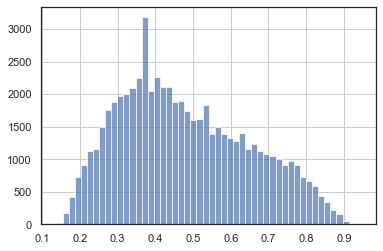

In [377]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_df.drop_duplicates('sentence')['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

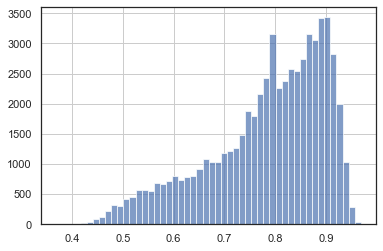

In [372]:
sns.set(style="white")
plt.figure()
score_df.drop_duplicates('sentence')['max_3'].hist(alpha=.7, bins=50)

<AxesSubplot:>

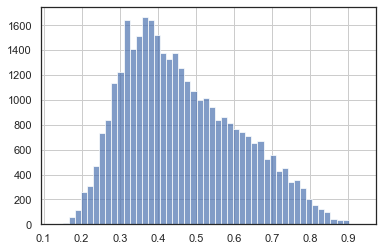

In [378]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_all_df[score_all_df.valid].drop_duplicates('revised_text')['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

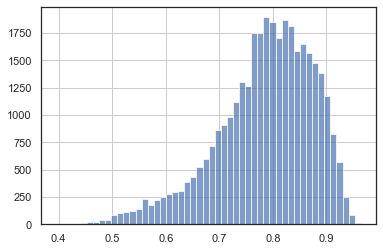

In [379]:
sns.set(style="white")
plt.figure()
score_all_df[score_all_df.valid].drop_duplicates('revised_text')['max_3'].hist(alpha=.7, bins=50)

<AxesSubplot:>

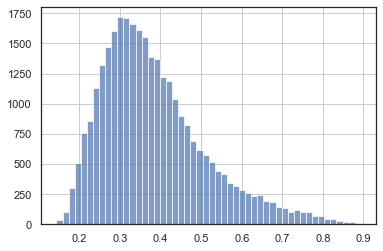

In [382]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_agg_df.drop_duplicates('BERT_767')['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

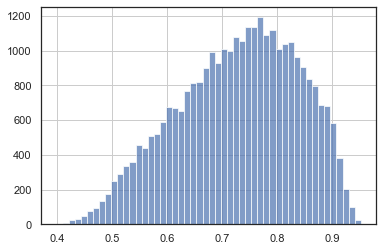

In [383]:
sns.set(style="white")
plt.figure()
score_agg_df.drop_duplicates('BERT_767')['max_3'].hist(alpha=.7, bins=50)

In [391]:
compare = score_agg_df.merge(score_all_df, how = 'left', left_on='origin', right_on='origin')

In [392]:
compare['max_1_eq'] = compare['max_1_col_x']==compare['max_1_col_y']

In [393]:
compare['max_1_eq'].mean()

0.5845693755895871

In [394]:
compare[compare['counts']>1]['max_1_eq'].mean()

0.4777979614491876

In [395]:
compare['max_3_eq'] = compare.apply(lambda x: IoU([x['max_1_col_x'],x['max_2_col_x'],x['max_3_col_x']],
                                                 [x['max_1_col_y'],x['max_2_col_y'],x['max_3_col_y']]),axis=1)

In [396]:
compare['max_3_eq'].mean()

0.6592798506713767

In [397]:
compare[compare['counts']>1]['max_3_eq'].mean()

0.5717100615601978

In [360]:
cp_dict_1 = {'max_{}_col_x'.format(i):'max_{}_col_agg'.format(i) for i in range(1,4,1)}

In [361]:
cp_dict_1

{'max_1_col_x': 'max_1_col_agg',
 'max_2_col_x': 'max_2_col_agg',
 'max_3_col_x': 'max_3_col_agg'}

In [362]:
compare.rename(columns=cp_dict_1)

,origin,Criteria i_x,Criteria ii_x,Criteria iii_x,Criteria iv_x,Criteria v_x,Criteria vi_x,Criteria vii_x,Criteria viii_x,Criteria ix_x,...,max_1_col_y,max_2_val_y,max_2_col_y,max_3_val_y,max_3_col_y,max_1_y,max_3_y,valid,max_1_eq,max_3_eq
0,6,0.259337,0.155953,0.075834,0.297092,0.007746,0.055644,0.106506,0.005868,0.006298,...,Criteria iv,0.183747,Criteria i,0.083780,Criteria iii,0.624199,0.891726,True,True,0.5
1,7,0.280106,0.160228,0.063887,0.287323,0.007405,0.052352,0.106599,0.005892,0.006322,...,Criteria iv,0.130004,Criteria i,0.083284,Criteria iii,0.690831,0.904119,True,True,0.5
2,10,0.159399,0.138270,0.050162,0.281527,0.024864,0.263155,0.026450,0.009823,0.007378,...,Criteria vi,0.083139,Criteria iv,0.070070,Criteria iii,0.687655,0.840863,True,False,0.5
3,11,0.064072,0.101100,0.138652,0.371870,0.037761,0.235550,0.014976,0.004089,0.004590,...,Criteria vi,0.228499,Criteria iv,0.111985,Criteria iii,0.390900,0.731383,True,False,1.0
4,12,0.026055,0.091389,0.111278,0.523049,0.037834,0.171121,0.011287,0.002796,0.002930,...,Criteria iv,0.166905,Criteria v,0.073843,Criteria iii,0.594140,0.834888,True,True,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49818,116670,0.142495,0.211500,0.176144,0.378178,0.009746,0.054499,0.002484,0.002402,0.001982,...,Criteria ii,0.383132,Criteria iv,0.121423,Criteria i,0.390654,0.895209,True,False,0.5
49819,116671,0.173027,0.614078,0.040978,0.116452,0.006094,0.011230,0.003096,0.005652,0.005847,...,Criteria ii,0.276984,Criteria i,0.114366,Criteria iv,0.511271,0.902621,True,True,1.0
49820,116672,0.386835,0.261040,0.074405,0.120150,0.005462,0.113419,0.004743,0.003938,0.003459,...,Criteria i,0.254000,Criteria ii,0.140171,Criteria iv,0.437061,0.831232,True,True,1.0
49821,116673,0.198778,0.341398,0.071989,0.298316,0.005472,0.048270,0.003934,0.004032,0.002994,...,Criteria ii,0.236940,Criteria i,0.130852,Criteria iv,0.548089,0.915880,True,True,1.0


In [363]:
score_final = score_all_df.merge(compare.rename(columns=cp_dict_1)[['origin','max_1_col_agg','max_2_col_agg','max_3_col_agg',
                                                    'max_1_eq','max_3_eq']], how='left', left_on='origin',right_on='origin')

In [364]:
score_final

,origin,index,index.1,owner,owner_loc,title,description,comments,taken,views,...,max_3_val,max_3_col,max_1,max_3,valid,max_1_col_agg,max_2_col_agg,max_3_col_agg,max_1_eq,max_3_eq
0,6,6,50770113131,148125504@N04,"Tarazona (Zaragoza), España",Venecia - Patio Palacio Minelli,El palacio Contarini del Bovolo (también llama...,3,2010-03-27 12:47:45,90,...,0.083780,Criteria iii,0.624199,0.891726,True,Criteria iv,Criteria i,Criteria ii,True,0.5
1,7,7,50770228312,148125504@N04,"Tarazona (Zaragoza), España",Venecia - Palacio Minelli,El palacio Contarini del Bovolo (también llama...,7,2010-03-27 12:45:28,238,...,0.083284,Criteria iii,0.690831,0.904119,True,Criteria iv,Criteria i,Criteria ii,True,0.5
2,10,10,50766039303,32980384@N05,"Berlin, Germany",_DSC7807,Canal Grande on Venetsian pääliikenneväylä. Ku...,0,2020-08-11 11:48:15,25,...,0.070070,Criteria iii,0.687655,0.840863,True,Criteria iv,Criteria vi,Criteria i,False,0.5
3,11,11,50766893587,32980384@N05,"Berlin, Germany",_DSC7805,Corona-rajoitusten aikaan oli hyvä tilaisuus k...,0,2020-08-11 11:44:31,27,...,0.111985,Criteria iii,0.390900,0.731383,True,Criteria iv,Criteria vi,Criteria iii,False,1.0
4,12,12,50766892772,32980384@N05,"Berlin, Germany",_DSC7802,Corona-rajoitusten aikaan oli hyvä tilaisuus k...,0,2020-08-11 11:43:19,20,...,0.073843,Criteria iii,0.594140,0.834888,True,Criteria iv,Criteria vi,Criteria iii,True,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958,116670,123096,20879329608,23097900@N02,Germany,Hier werden die Pakete mit dem Lastkahn zugest...,"<a href=""http://www.brusatotrasporti.it/index....",0,2015-07-03 11:34:58,244,...,0.121423,Criteria i,0.390654,0.895209,True,Criteria iv,Criteria ii,Criteria iii,False,0.5
80959,116671,123097,21040989736,23097900@N02,Germany,Tür No.342,NaN,0,2015-07-03 11:04:10,156,...,0.114366,Criteria iv,0.511271,0.902621,True,Criteria ii,Criteria i,Criteria iv,True,1.0
80960,116672,123098,20880415099,23097900@N02,Germany,Ave Maria,NaN,0,2015-07-03 11:34:25,163,...,0.140171,Criteria iv,0.437061,0.831232,True,Criteria i,Criteria ii,Criteria iv,True,1.0
80961,116673,123099,20879281658,23097900@N02,Germany,Kirchenportal der Chiesa di Santa Sofia.,NaN,0,2015-07-03 12:46:41,237,...,0.130852,Criteria iv,0.548089,0.915880,True,Criteria ii,Criteria iv,Criteria i,True,1.0


In [365]:
score_df.to_csv('../../../Venice_Flickr/data_storage/images/sentences_bert.csv',sep='\t', encoding='utf-8-sig')
score_final.to_csv('../../../Venice_Flickr/data_storage/images/metadata_bert.csv',sep='\t', encoding='utf-8-sig')

## END